In [1]:
library(dplyr)
library(Seurat)
library(patchwork)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching SeuratObject



In [2]:
library(ggplot2)
library(cowplot)


Attaching package: ‘cowplot’


The following object is masked from ‘package:patchwork’:

    align_plots




In [3]:
## remove the x-axis text and tick
## plot.margin to adjust the white space between each plot.
## ... pass any arguments to VlnPlot in Seurat
modify_vlnplot<- function(obj, 
                          feature, 
                          pt.size = 0, 
                          plot.margin = unit(c(-0.75, 0, -0.75, 0), "cm"),
                          ...) {
  p<- VlnPlot(obj, features = feature, pt.size = pt.size, ... )  + 
    xlab("") + ylab(feature) + ggtitle("") + 
    theme(legend.position = "none", 
          axis.text.x = element_blank(), 
          axis.ticks.x = element_blank(), 
          axis.title.y = element_text(size = rel(1), angle = 0), 
          axis.text.y = element_text(size = rel(1)), 
          plot.margin = plot.margin ) 
  return(p)
}

## extract the max value of the y axis
extract_max<- function(p){
  ymax<- max(ggplot_build(p)$layout$panel_scales_y[[1]]$range$range)
  return(ceiling(ymax))
}


## main function
StackedVlnPlot<- function(obj, features,
                          pt.size = 0, 
                          plot.margin = unit(c(-0.75, 0, -0.75, 0), "cm"),
                          ...) {
  
  plot_list<- purrr::map(features, function(x) modify_vlnplot(obj = obj,feature = x, ...))
  
  # Add back x-axis title to bottom plot. patchwork is going to support this?
  plot_list[[length(plot_list)]]<- plot_list[[length(plot_list)]] +
    theme(axis.text.x=element_text(), axis.ticks.x = element_line())
  
  # change the y-axis tick to only max value 
  ymaxs<- purrr::map_dbl(plot_list, extract_max)
  plot_list<- purrr::map2(plot_list, ymaxs, function(x,y) x + 
                            scale_y_continuous(breaks = c(y)) + 
                            expand_limits(y = y))

  p<- patchwork::wrap_plots(plotlist = plot_list, ncol = 1)
  return(p)
}

In [4]:
normal.data <- Read10X(data.dir = "/together_sdg/sc0413/RNA3/WJ-3/WJ-3/outs/filtered_feature_bc_matrix")
normal <- CreateSeuratObject(counts = normal.data, project = "poems14", min.cells = 3, min.features = 100)

In [5]:
normal

An object of class Seurat 
20752 features across 9659 samples within 1 assay 
Active assay: RNA (20752 features, 0 variable features)

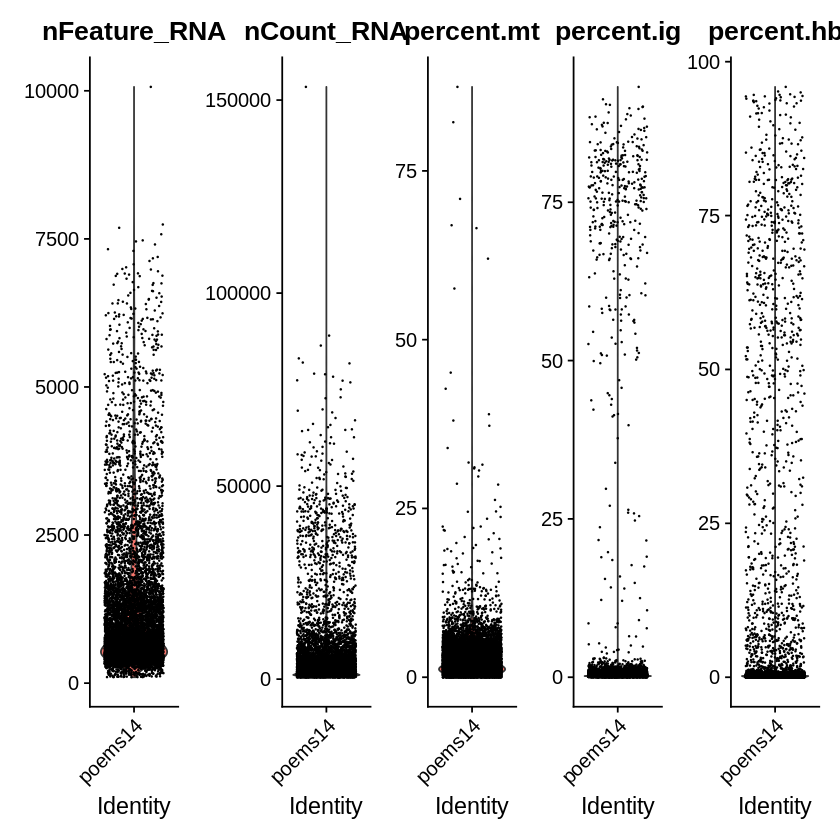

In [6]:
normal[["percent.mt"]] <- PercentageFeatureSet(normal, pattern = "^MT-")
normal[["percent.ig"]] <- PercentageFeatureSet(normal, pattern = "^IG")
normal[["percent.hb"]] <- PercentageFeatureSet(normal, pattern = "^HB")
VlnPlot(normal, features = c("nFeature_RNA", "nCount_RNA", "percent.mt","percent.ig","percent.hb"), ncol = 5)

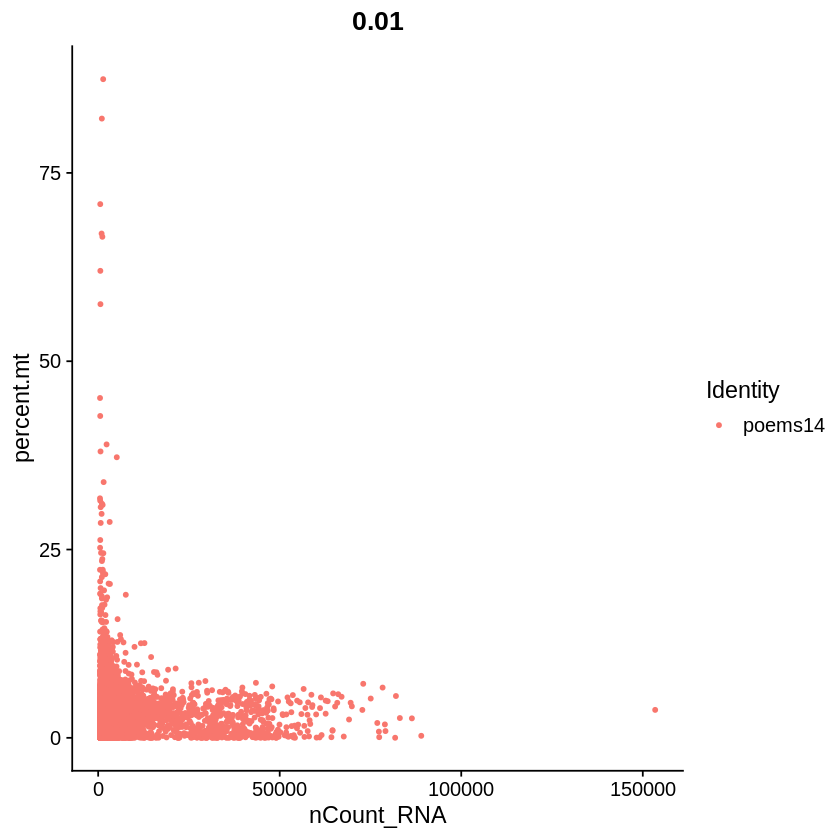

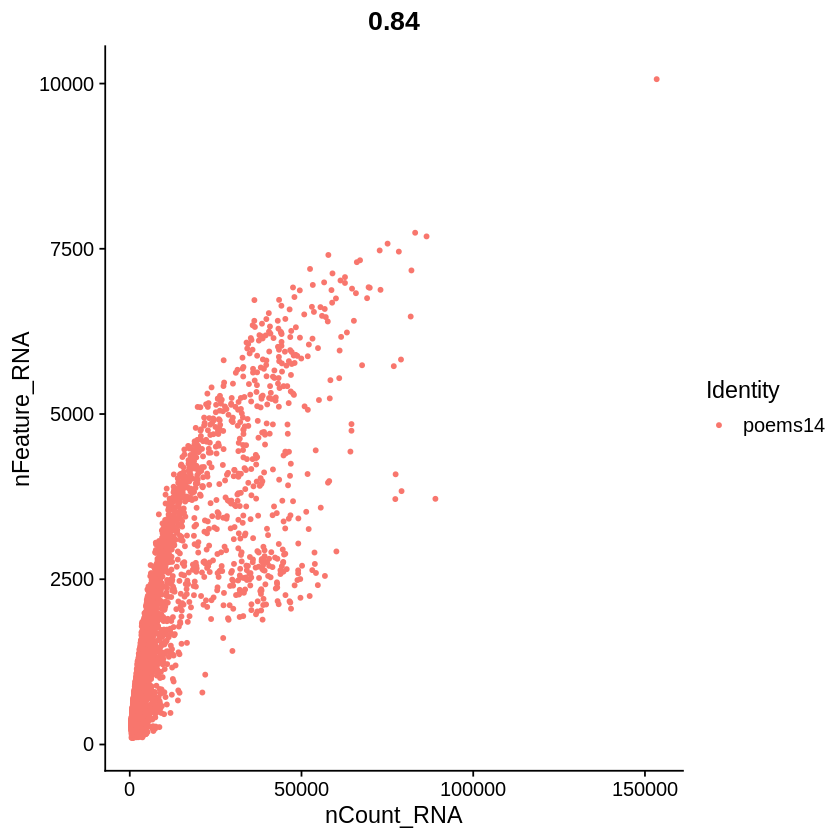

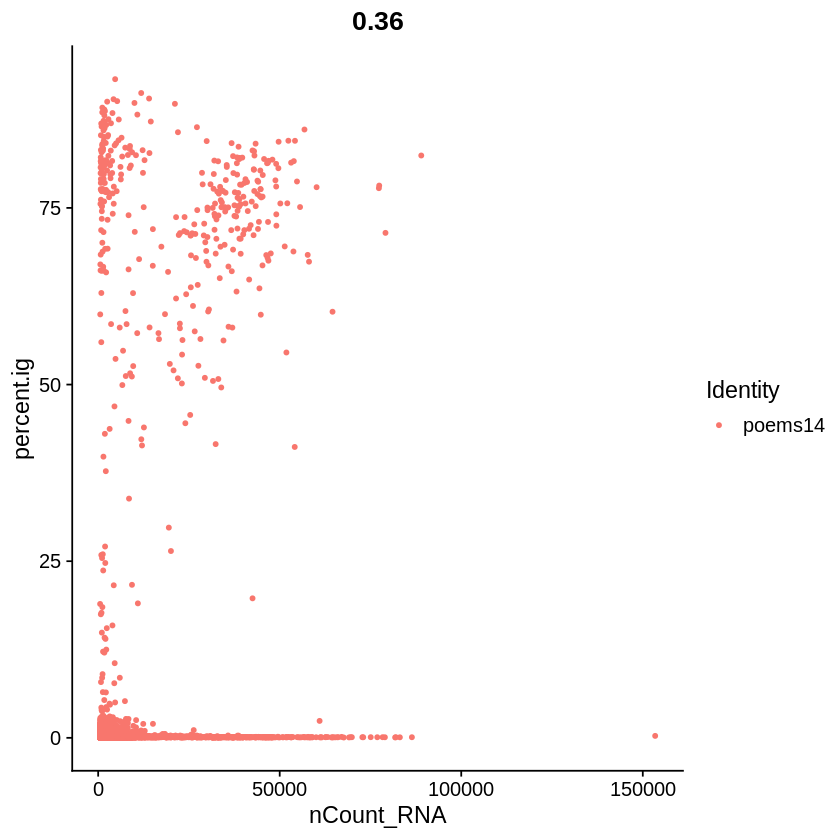

In [7]:
plot1 <- FeatureScatter(normal, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(normal, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
plot3 <- FeatureScatter(normal, feature1 = "nCount_RNA", feature2 = "percent.ig")
plot1
plot2
plot3

In [8]:
normal <- subset(normal, subset = nFeature_RNA > 100 & nFeature_RNA < 5000 & percent.mt < 10 & percent.hb<1)
normal

An object of class Seurat 
20752 features across 8284 samples within 1 assay 
Active assay: RNA (20752 features, 0 variable features)

In [9]:
normal <- NormalizeData(normal, normalization.method = "LogNormalize", scale.factor = 10000)

When using repel, set xnudge and ynudge to 0 for optimal results

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 141 rows containing missing values (geom_point).”
Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 141 rows containing missing values (geom_point).”


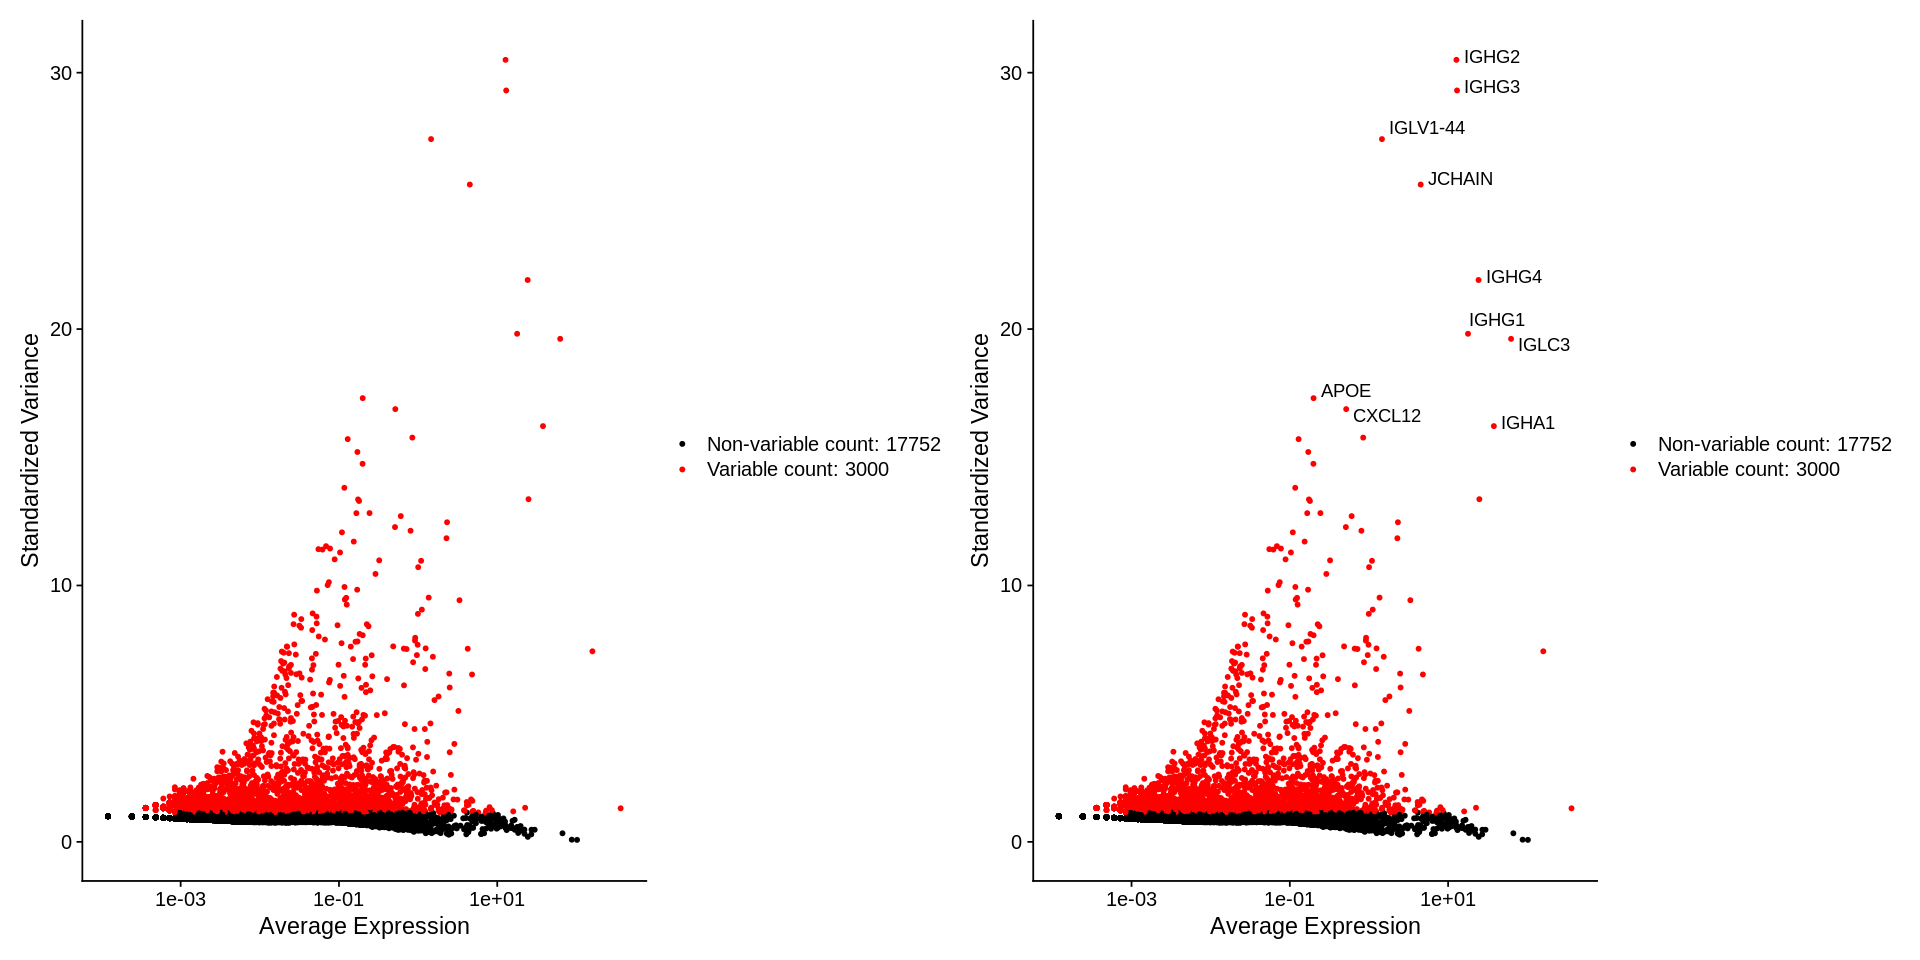

In [10]:
normal <- FindVariableFeatures(normal, selection.method = "vst", nfeatures = 3000)

# Identify the 10 most highly variable genes
top10 <- head(VariableFeatures(normal), 10)

# plot variable features with and without labels
plot1 <- VariableFeaturePlot(normal)
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE)
options(repr.plot.height=8,repr.plot.width=16)
plot1+plot2

In [11]:
all.genes <- rownames(normal)
normal <- ScaleData(normal, features = all.genes)

Centering and scaling data matrix



In [12]:
length(VariableFeatures(object = normal))

[1] 3000

In [13]:
normal <- RunPCA(normal, features = VariableFeatures(object = normal))

PC_ 1 
Positive:  RPL10A, RPS4X, RPLP0, RPS5, RPS2, RPL7A, EEF1B2, PPIA, NME2, HSP90AB1 
	   RPL5, CD74, RPL4, EEF1G, S100A10, RACK1, MIF, HLA-DRB1, HLA-DRA, NPM1 
	   SLC25A6, HINT1, HNRNPA1, ANXA2, GSTP1, AHNAK, CD52, LDHB, HLA-DPA1, HLA-DPB1 
Negative:  CAMP, G0S2, FCGR3B, CLC, TFF3, PTGS2, LYZ, RETN, CMTM2, IL1R2 
	   RGS2, CD177, SOD2, MME, CXCR2, CTSS, SLC40A1, OLFM4, FCN1, ABCA13 
	   HBB, TNFAIP6, NAMPT, IGKC, CXCL1, PTX3, RGS18, HIST1H2AC, TRIB1, SERPINA1 
PC_ 2 
Positive:  IL32, CD3D, TRBC2, CD3E, CD2, CD3G, ARL4C, GZMA, GZMM, CCL5 
	   TRAC, BCL11B, PCED1B-AS1, CD69, LCK, CD7, CD247, LIME1, CTSW, CCL4 
	   KLRB1, TRBC1, PRF1, IKZF3, RORA, IL7R, GZMK, PYHIN1, SAMD3, ITM2A 
Negative:  LYZ, VCAN, MS4A6A, CST3, CD36, IFI30, CD14, KLF4, MPEG1, CD68 
	   AC020656.1, FCN1, FOS, TMEM176B, FGL2, GASK1B, AIF1, KCTD12, MARCH1, CTSS 
	   CPVL, APLP2, ASGR1, SLC7A7, TMEM176A, CSTA, MAFB, LRP1, CTSB, HNMT 
PC_ 3 
Positive:  FTH1, ZFP36L1, DUSP1, LRP1, HLA-C, CYP1B1, RGS2, NAMPT, CTSS, CD1

In [14]:
options(repr.plot.height=8,repr.plot.width=8)

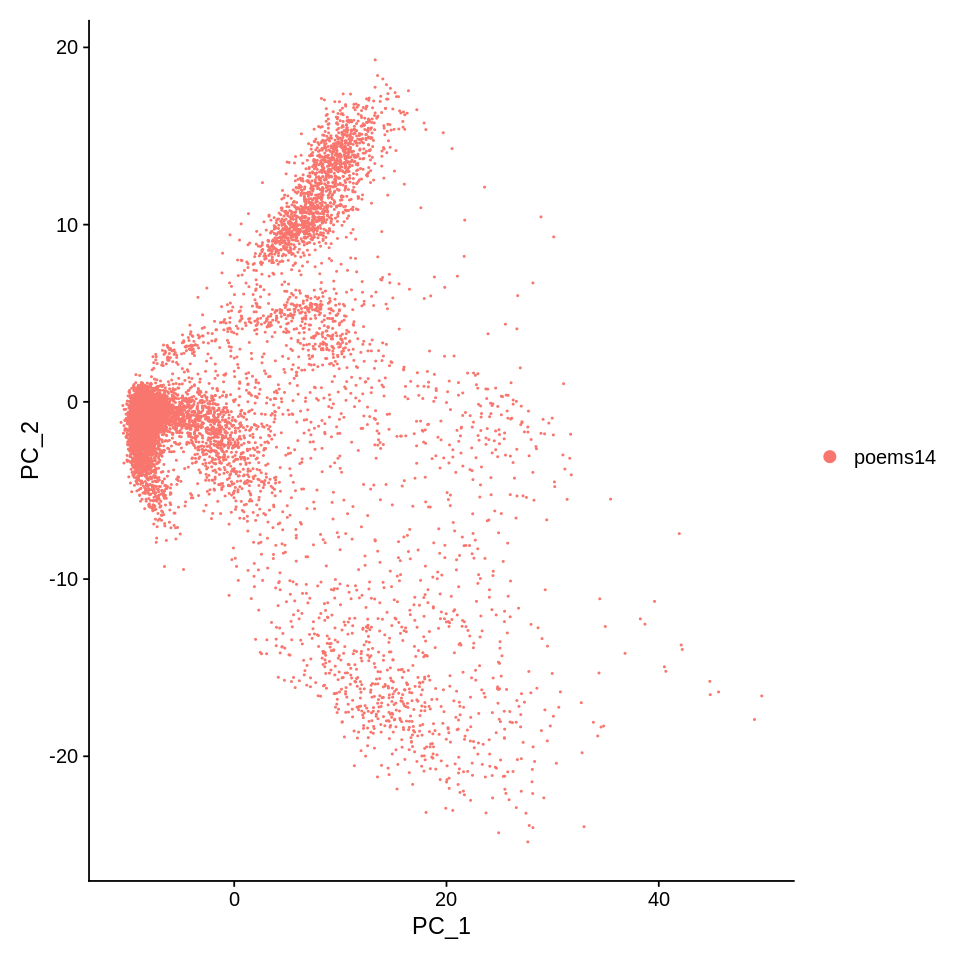

In [15]:
DimPlot(normal, reduction = "pca")

In [16]:
normal <- JackStraw(normal, num.replicate = 100)
normal <- ScoreJackStraw(normal, dims = 1:20)

Warning message:
“Removed 42000 rows containing missing values (geom_point).”


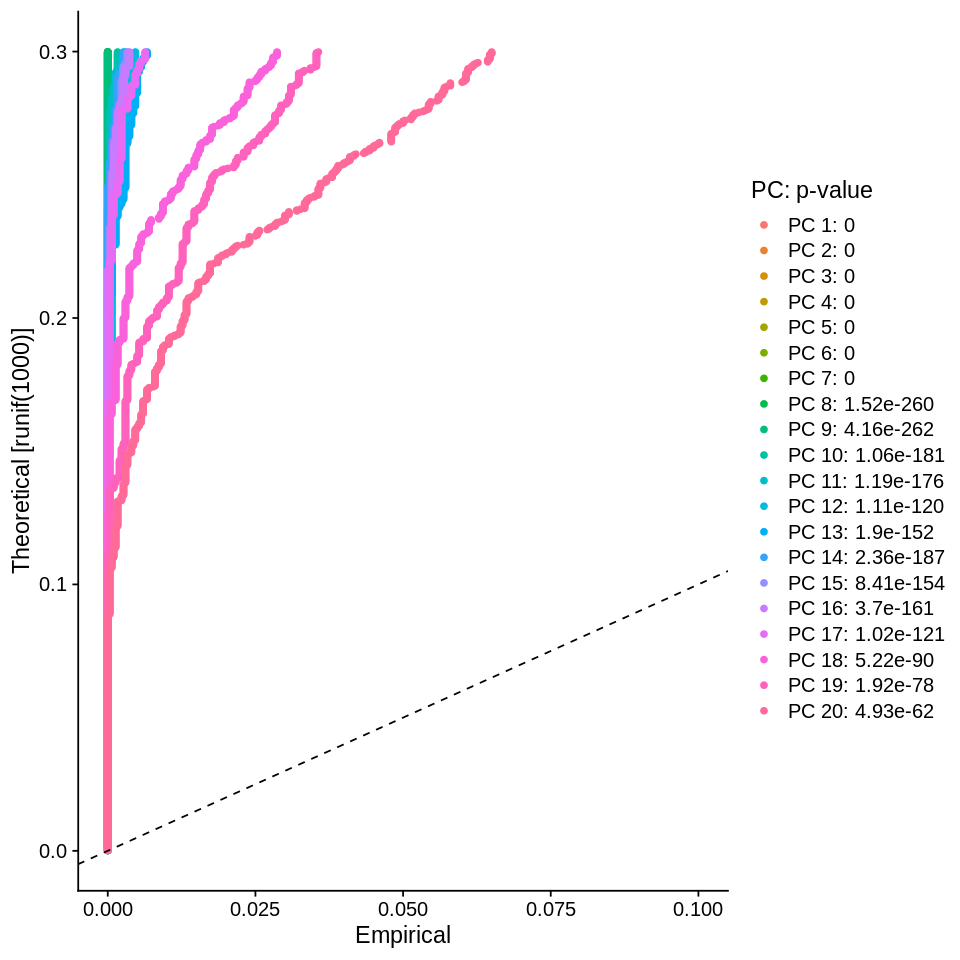

In [17]:
JackStrawPlot(normal, dims = 1:20)

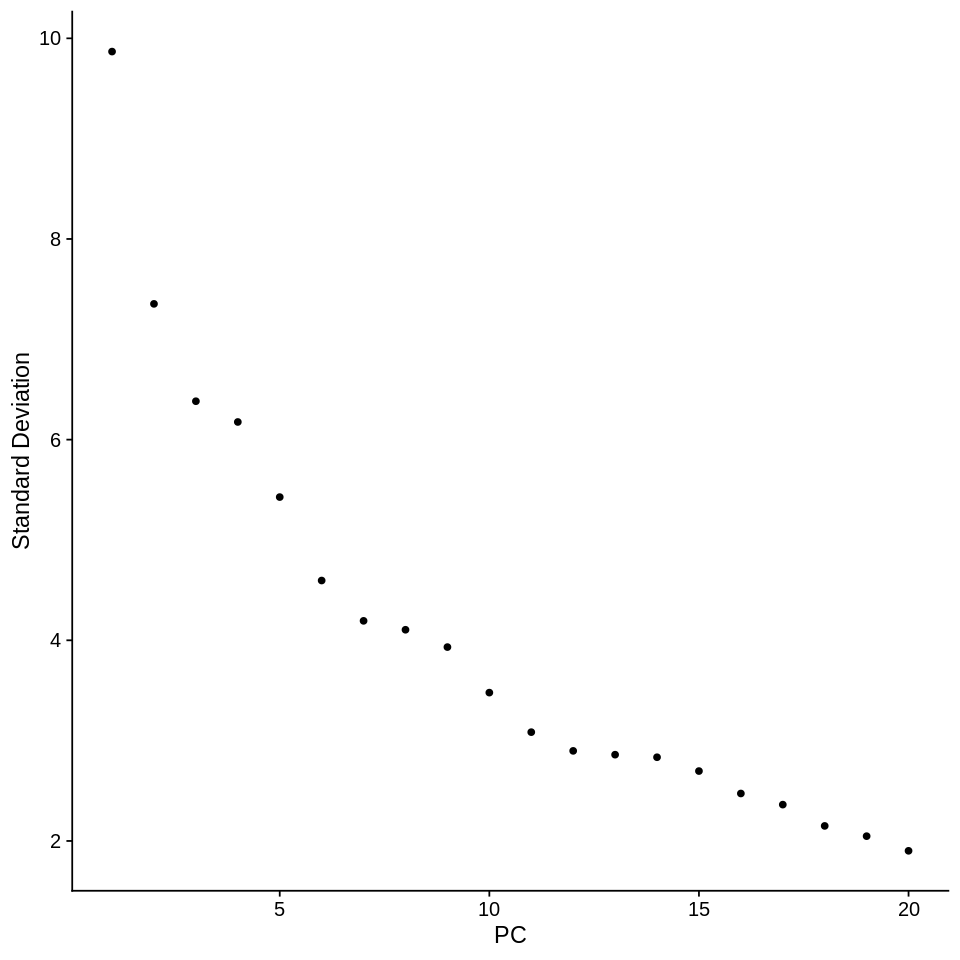

In [18]:
ElbowPlot(normal)

In [19]:
normal <- RunUMAP(normal, dims = 1:14)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
17:22:05 UMAP embedding parameters a = 0.9922 b = 1.112

17:22:05 Read 8284 rows and found 14 numeric columns

17:22:05 Using Annoy for neighbor search, n_neighbors = 30

17:22:05 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

17:22:06 Writing NN index file to temp file /tmp/Rtmp4Smlnh/file2e1a6214d7db8

17:22:07 Searching Annoy index using 1 thread, search_k = 3000

17:22:10 Annoy recall = 100%

17:22:10 Commencing smooth kNN distance calibration using 1 thread

17:22:11 Initializing fr

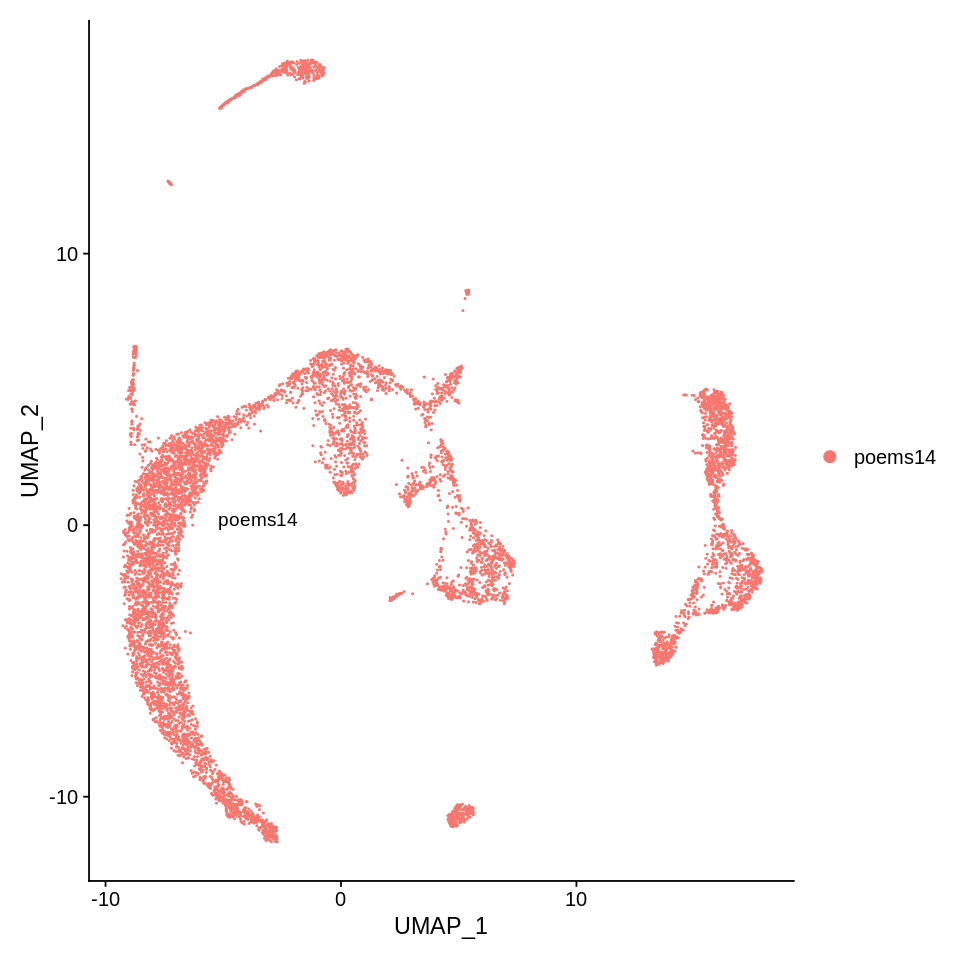

In [20]:
DimPlot(normal, reduction = "umap",label=T)

Loading required package: fields

Loading required package: spam

Loading required package: dotCall64

Loading required package: grid

Spam version 2.7-0 (2021-06-25) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.


Attaching package: ‘spam’


The following objects are masked from ‘package:base’:

    backsolve, forwardsolve


Loading required package: viridis

Loading required package: viridisLite

See https://github.com/NCAR/Fields for
 an extensive vignette, other supplements and source code 



[1] "Creating artificial doublets for pN = 5%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 10%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 15%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 20%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 25%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 30%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."


Loading required package: KernSmooth

KernSmooth 2.23 loaded
Copyright M. P. Wand 1997-2009

Loading required package: ROCR

Loading required package: modes



NULL


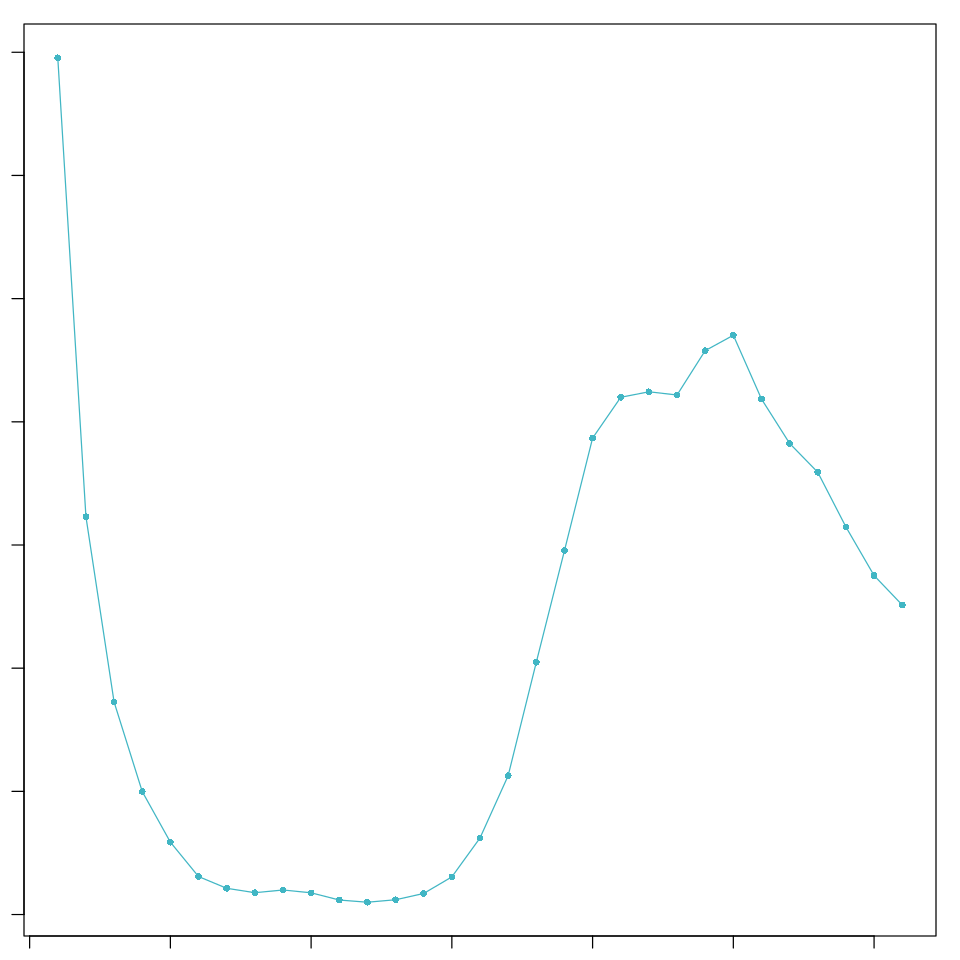

In [21]:
library(DoubletFinder)
sweep.res.list <- paramSweep_v3(normal, PCs = 1:14, sct = FALSE)
for(i in 1:length(sweep.res.list)){
  if(length(sweep.res.list[[i]]$pANN[is.nan(sweep.res.list[[i]]$pANN)]) != 0){
    if(i != 1){
      sweep.res.list[[i]] <- sweep.res.list[[i - 1]]
    }else{
      sweep.res.list[[i]] <- sweep.res.list[[i + 1]]
    }
  }
}
sweep.stats <- summarizeSweep(sweep.res.list, GT = FALSE)
bcmvn <- find.pK(sweep.stats)
pk_v <- as.numeric(as.character(bcmvn$pK))
pk_good <- pk_v[bcmvn$BCmetric==max(bcmvn$BCmetric)]
nExp_poi <- round(0.1*length(colnames(normal)))

In [22]:
normal <- doubletFinder_v3(normal, PCs = 1:14, pN = 0.25, pK = pk_good, nExp = nExp_poi, reuse.pANN = FALSE, sct = FALSE)

[1] "Creating 2761 artificial doublets..."
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Computing pANN..."
[1] "Classifying doublets.."


In [23]:
colnames(normal@meta.data)[ncol(normal@meta.data)]="DoubletFinder"

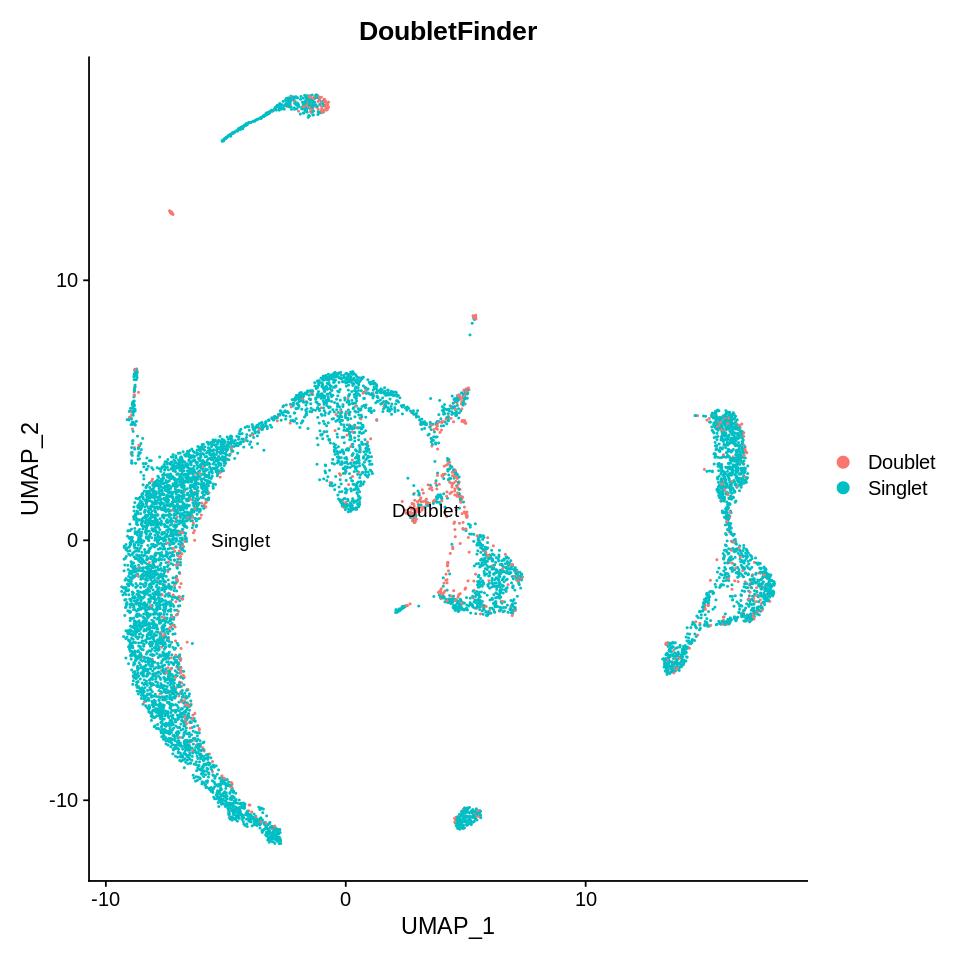

In [24]:
DimPlot(normal, reduction = "umap",label=T,group.by='DoubletFinder')

In [25]:
normal2<-subset(normal,DoubletFinder=='Singlet')

In [26]:
normal
normal2

An object of class Seurat 
20752 features across 8284 samples within 1 assay 
Active assay: RNA (20752 features, 3000 variable features)
 2 dimensional reductions calculated: pca, umap

An object of class Seurat 
20752 features across 7456 samples within 1 assay 
Active assay: RNA (20752 features, 3000 variable features)
 2 dimensional reductions calculated: pca, umap

When using repel, set xnudge and ynudge to 0 for optimal results

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 408 rows containing missing values (geom_point).”
Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 408 rows containing missing values (geom_point).”


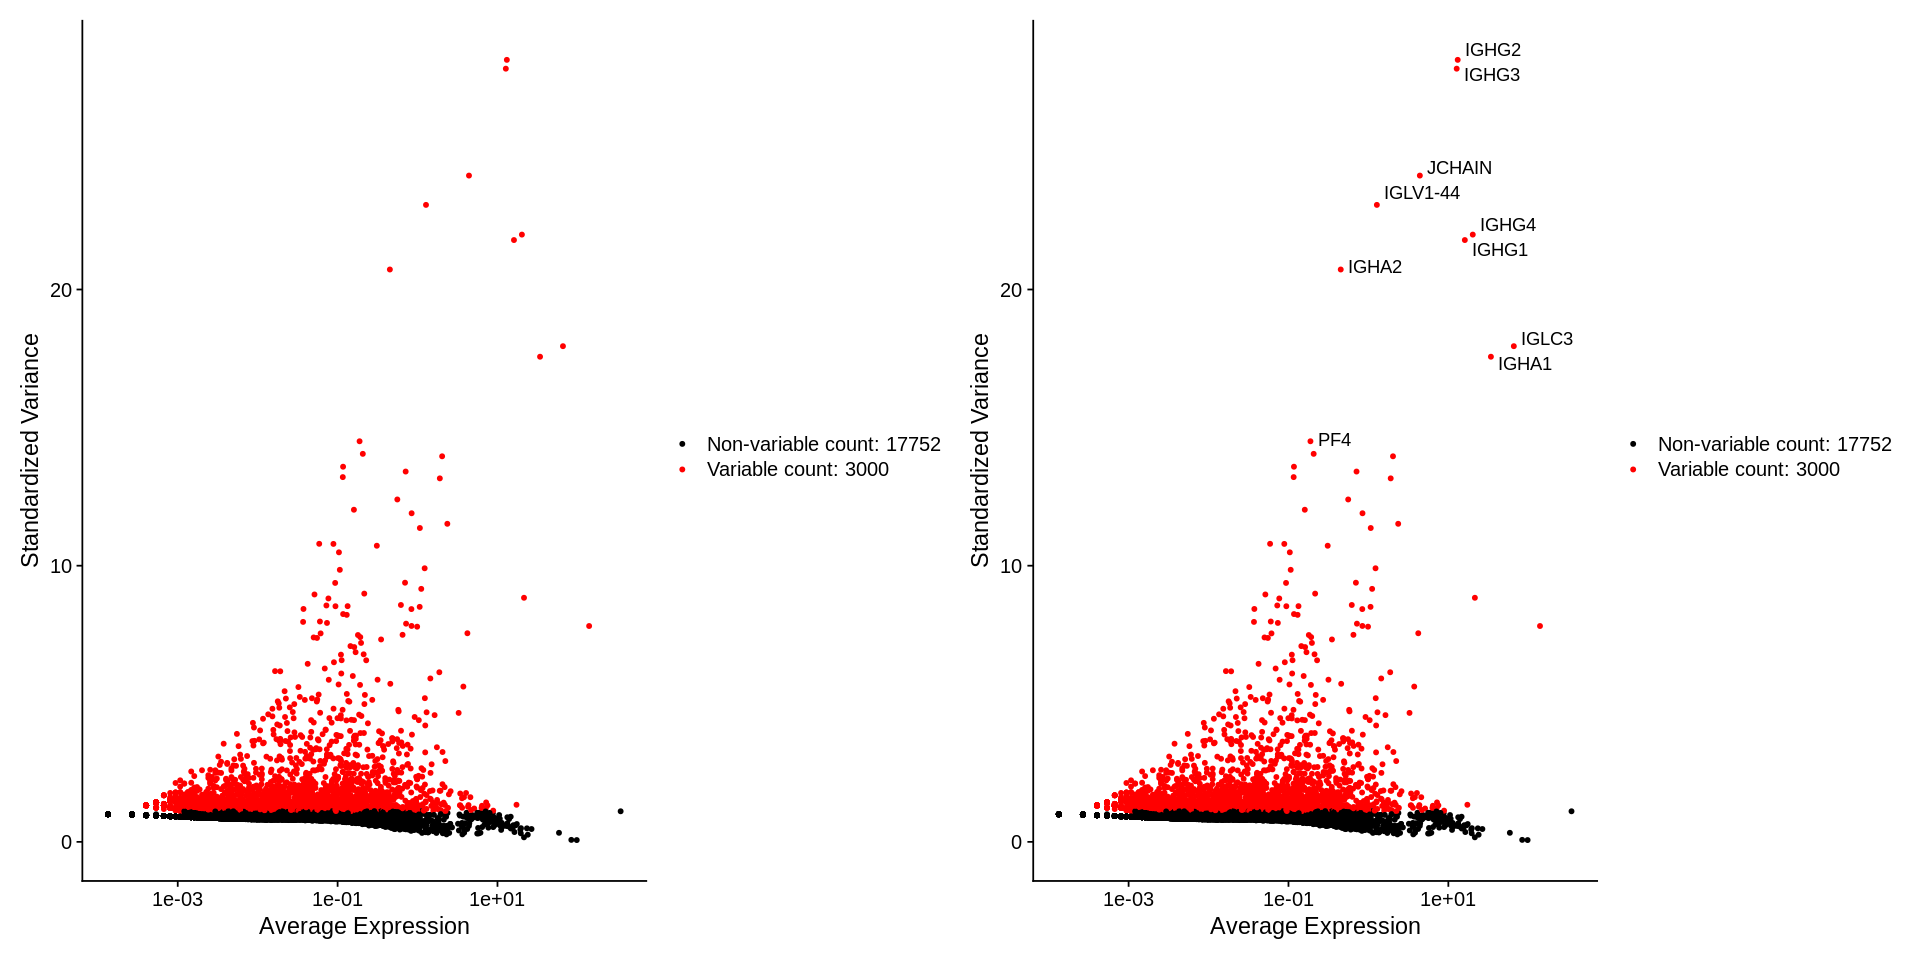

In [27]:
normal2 <- FindVariableFeatures(normal2, selection.method = "vst", nfeatures = 3000)

# Identify the 10 most highly variable genes
top10 <- head(VariableFeatures(normal2), 10)

# plot variable features with and without labels
plot1 <- VariableFeaturePlot(normal2)
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE)
options(repr.plot.height=8,repr.plot.width=16)
plot1+plot2

In [28]:
all.genes <- rownames(normal2)
normal2 <- ScaleData(normal2, features = all.genes)

Centering and scaling data matrix



In [29]:
length(VariableFeatures(object = normal2))

[1] 3000

In [30]:
normal2 <- RunPCA(normal2, features = VariableFeatures(object = normal2))

PC_ 1 
Positive:  RPL10A, RPS4X, RPS5, RPS2, RPSA, RPLP0, RPL36A, RPL7A, EEF1B2, RPL5 
	   PTMA, CD52, PPIA, HSP90AB1, RPL4, NME2, RACK1, S100A10, EEF1G, NPM1 
	   RPS6, HINT1, MIF, RPL31, SLC25A6, CD99, HNRNPA1, LDHB, CRIP1, SNHG6 
Negative:  CAMP, LYZ, G0S2, FCGR3B, CLC, PTGS2, TFF3, RETN, TYROBP, CMTM2 
	   RGS2, IL1R2, CTSS, FCN1, SOD2, MME, CD177, PROK2, CXCR2, NAMPT 
	   CHI3L1, CHIT1, OLFM4, HBB, ABCA13, AC020656.1, CXCL1, CSTA, PTX3, FOS 
PC_ 2 
Positive:  VCAN, CD36, CST3, CD14, MS4A6A, IFI30, TMEM176B, MPEG1, KLF4, CD68 
	   MARCH1, MAFB, SLC7A7, GASK1B, LRP1, ASGR1, CPVL, FGL2, TMEM176A, CYP1B1 
	   LGALS2, AIF1, LYZ, CTSB, FOS, APLP2, KCTD12, CLEC7A, TGFBI, LY86 
Negative:  IL32, CD3D, ARL4C, CD3E, TRBC2, CD3G, CD2, GZMM, GZMA, TRAC 
	   BCL11B, CCL5, PCED1B-AS1, CD69, LCK, CD7, CD247, LIME1, CTSW, EVL 
	   TRBC1, CCL4, KLRB1, PLAAT4, IL7R, PRF1, RORA, GZMK, IKZF3, ITM2A 
PC_ 3 
Positive:  STMN1, MS4A3, AZU1, PCLAF, RNASE2, TYMS, ELANE, MPO, PRTN3, DEFA3 
	   DEFA4, NUCB2, 

In [31]:
normal2 <- JackStraw(normal2, num.replicate = 100)
normal2 <- ScoreJackStraw(normal2, dims = 1:20)

Warning message:
“Removed 42000 rows containing missing values (geom_point).”


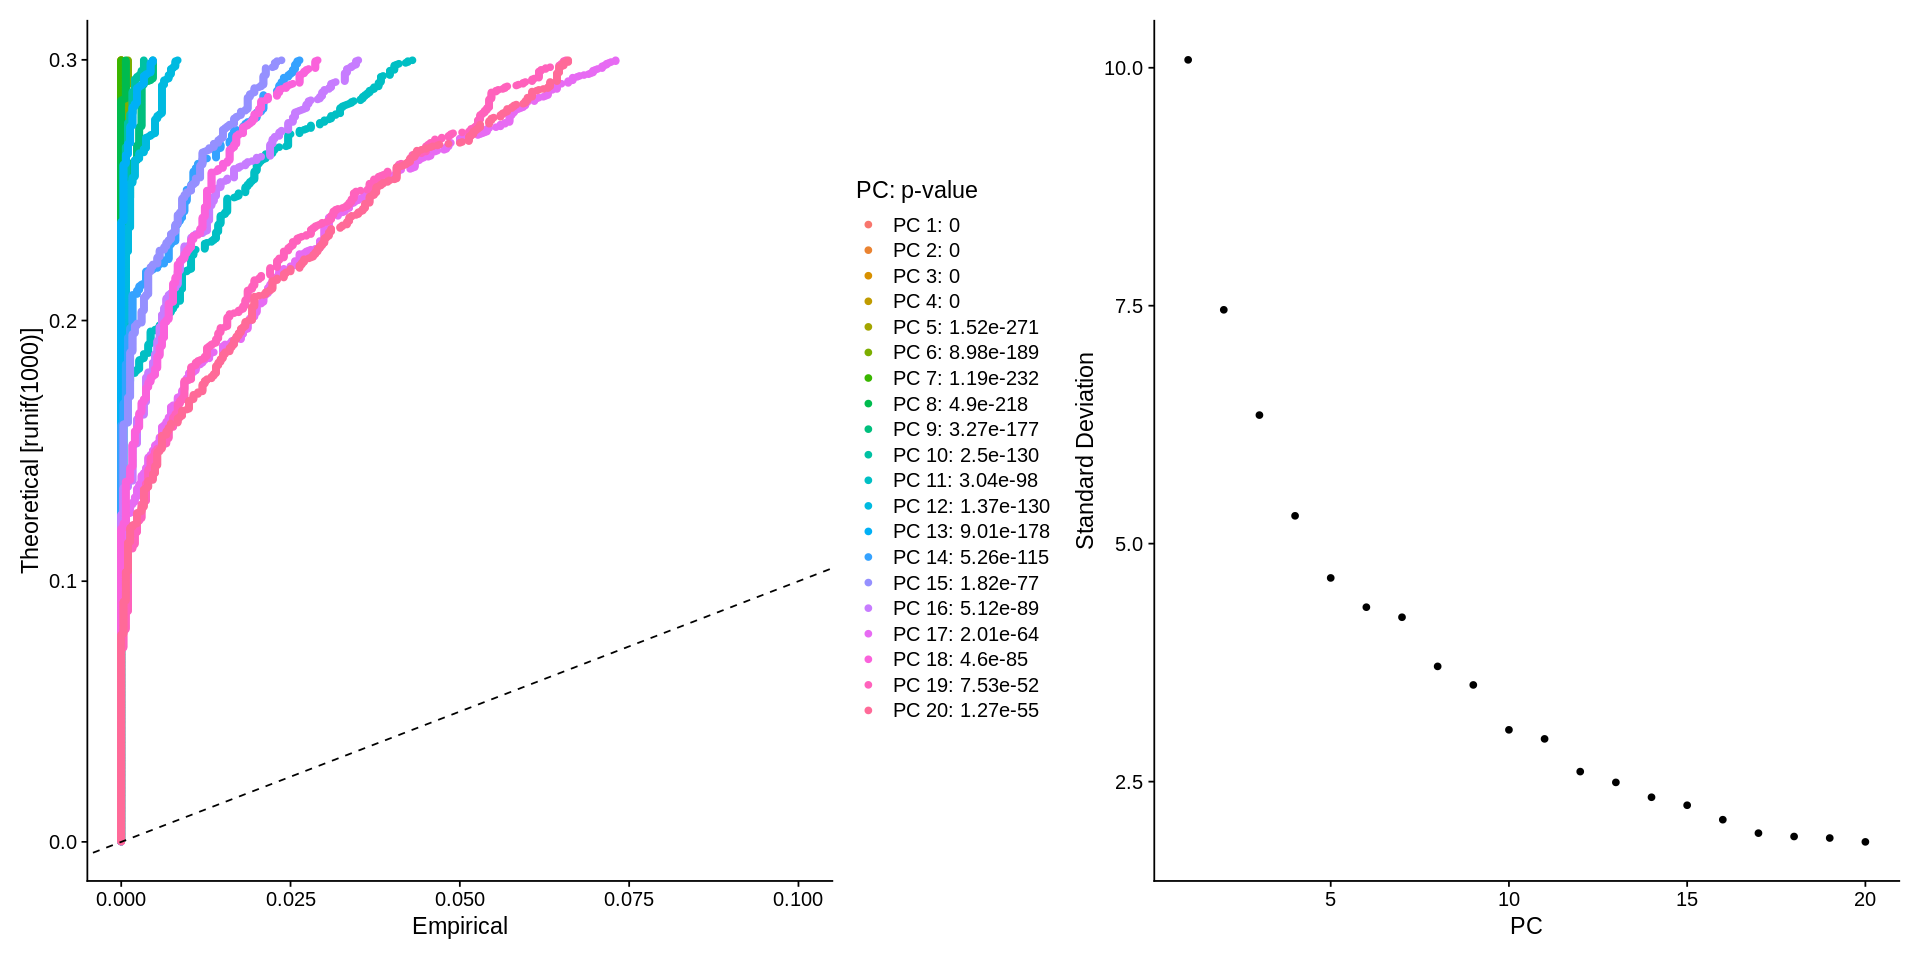

In [32]:
jplot<-JackStrawPlot(normal2, dims = 1:20)
eplot<-ElbowPlot(normal2)
options(repr.plot.height=8,repr.plot.width=16)
jplot+eplot

In [33]:
normal2 <- FindNeighbors(normal2, dims = 1:14)
normal2 <- FindClusters(normal2, resolution = 0.4)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 7456
Number of edges: 265359

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9272
Number of communities: 12
Elapsed time: 1 seconds


In [34]:
normal2 <- RunUMAP(normal2, dims = 1:14)

17:31:33 UMAP embedding parameters a = 0.9922 b = 1.112

17:31:33 Read 7456 rows and found 14 numeric columns

17:31:33 Using Annoy for neighbor search, n_neighbors = 30

17:31:33 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

17:31:35 Writing NN index file to temp file /tmp/Rtmp4Smlnh/file2e1a63ae62eb3

17:31:35 Searching Annoy index using 1 thread, search_k = 3000

17:31:37 Annoy recall = 100%

17:31:38 Commencing smooth kNN distance calibration using 1 thread

17:31:39 Found 2 connected components, 
falling back to 'spca' initialization with init_sdev = 1

17:31:39 Initializing from PCA

17:31:39 PCA: 2 components explained 45.42% variance

17:31:39 Commencing optimization for 500 epochs, with 311934 positive edges

17:31:51 Optimization finished



In [35]:
options(repr.plot.height=8,repr.plot.width=8)

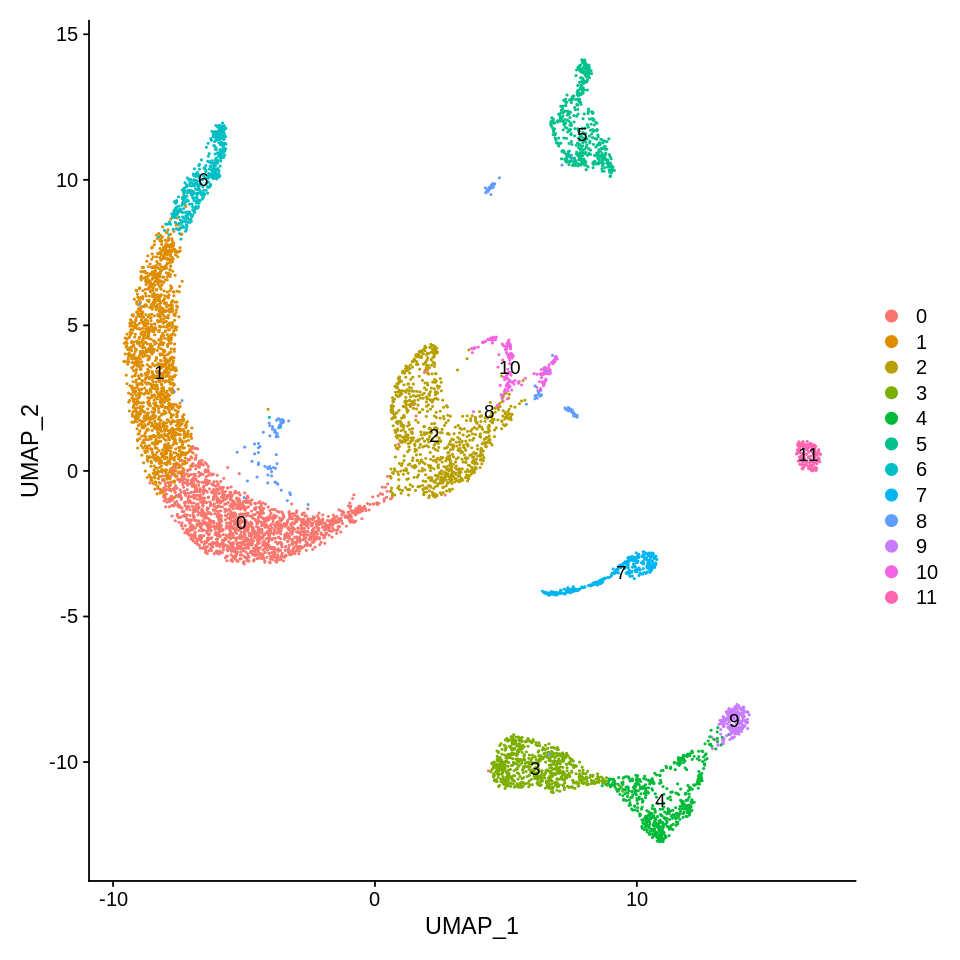

In [36]:
DimPlot(normal2, reduction = "umap",label=T)

In [37]:
load('/together_sdc/zhoujiaqi/sc0418/RNA/imgs.xxy/HPCA.Rdata')
load('/together_sdc/zhoujiaqi/sc0418/RNA/imgs.xxy/NHD.RData')
library(Seurat)
library(SingleR)
library(viridis)
library(pheatmap)

Loading required package: SummarizedExperiment

Loading required package: GenomicRanges

Loading required package: stats4


Attaching package: ‘stats4’


The following object is masked from ‘package:spam’:

    mle


Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:spam’:

    cbind, rbind


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filte

In [38]:
#进行singleR注释
AL_for_SingleR <- GetAssayData(normal2, slot="data") ##获取标准化矩阵

In [39]:
#先从cluster分辨率注释
clusterann<-SingleR(AL_for_SingleR, hpca.se, method="cluster", clusters=normal2@meta.data$seurat_clusters,labels=hpca.se$label.main)
#　save(clusterann,file="/together_sdb/zhoujiaqi/sc0418/RNA/imgs.xxy/AL1.M/dim8_res0.8/clusterann.Rdata")
clusterann
clusterann<-as.data.frame(row.names=clusterann@rownames,clusterann$labels)

Warning message:
“Argument 'center' should be of the same length as number of rows of 'x'. Use of a scalar value is deprecated: 1 != 2”
Warning message:
“Argument 'center' should be of the same length as number of rows of 'x'. Use of a scalar value is deprecated: 1 != 26”
Warning message:
“Argument 'center' should be of the same length as number of rows of 'x'. Use of a scalar value is deprecated: 1 != 7”
Warning message:
“Argument 'center' should be of the same length as number of rows of 'x'. Use of a scalar value is deprecated: 1 != 8”
Warning message:
“Argument 'center' should be of the same length as number of rows of 'x'. Use of a scalar value is deprecated: 1 != 2”
Warning message:
“Argument 'center' should be of the same length as number of rows of 'x'. Use of a scalar value is deprecated: 1 != 88”
Warning message:
“Argument 'center' should be of the same length as number of rows of 'x'. Use of a scalar value is deprecated: 1 != 17”
Warning message:
“Argument 'center' should be

DataFrame with 12 rows and 5 columns
                            scores  first.labels      tuning.scores
                          <matrix>   <character>        <DataFrame>
0   0.178416:0.477752:0.714719:...     Myelocyte 0.823944:0.7338215
1   0.155675:0.474134:0.700402:...     Myelocyte 0.493844:0.0802551
2   0.257219:0.505384:0.728399:... Pro-Myelocyte 0.549698:0.2673196
3   0.278345:0.620769:0.565884:...       T_cells 0.797136:0.7234762
4   0.269775:0.599385:0.555909:...       NK_cell 0.543480:0.4321040
...                            ...           ...                ...
7   0.299431:0.647904:0.595972:...        B_cell  0.244507:0.185690
8   0.242443:0.433016:0.669562:...            BM  0.523565:0.396020
9   0.268052:0.576281:0.547126:...       NK_cell  0.793884:0.705593
10  0.341612:0.571648:0.712230:...           GMP  0.526111:0.400425
11  0.267726:0.751380:0.549406:...        B_cell  0.751380:0.619078
           labels pruned.labels
      <character>   <character>
0       Myelocy

In [40]:
AL.nhsc <- SingleR(test = AL_for_SingleR, ref= nhd.se, labels = nhd.se$label.main) 

Warning message:
“Argument 'center' should be of the same length as number of rows of 'x'. Use of a scalar value is deprecated: 1 != 29”
Warning message:
“Argument 'center' should be of the same length as number of rows of 'x'. Use of a scalar value is deprecated: 1 != 6”
Warning message:
“Argument 'center' should be of the same length as number of rows of 'x'. Use of a scalar value is deprecated: 1 != 21”
Warning message:
“Argument 'center' should be of the same length as number of rows of 'x'. Use of a scalar value is deprecated: 1 != 24”
Warning message:
“Argument 'center' should be of the same length as number of rows of 'x'. Use of a scalar value is deprecated: 1 != 4”
Warning message:
“Argument 'center' should be of the same length as number of rows of 'x'. Use of a scalar value is deprecated: 1 != 10”
Warning message:
“Argument 'center' should be of the same length as number of rows of 'x'. Use of a scalar value is deprecated: 1 != 5”
Warning message:
“Argument 'center' should b

In [41]:
meta=normal2@meta.data
table(AL.nhsc$labels,meta$seurat_clusters)
normal2@meta.data$labels <-AL.nhsc$labels

                 
                     0    1    2    3    4    5    6    7    8    9   10   11
  B cells            0    0    0    0    0    0    0  175    1    0    1  142
  Basophils          0    0    0    0    0    0    0   23    1    0    0    9
  CD4+ T cells       1    0    0  518    4    0    0    0    1    0    0    0
  CD8+ T cells       0    0    0  148  474    0    0    0    0    1    1    0
  CMPs               0    1   52    0    0    0    0    9    1    0   44    0
  Dendritic cells    0    0    0    0    0    0    0    3    1    0    3    0
  Eosinophils        1    0    2    0    0    0    0   23    1    0    0    0
  Erythroid cells    0    0    7    0    0    0    0    0   37    0   16    0
  GMPs               0    0   22    0    0    0    0    1    1    0    4    0
  Granulocytes     312   88  155    4    2    0    4   36   12    3    0    0
  HSCs               0    0    0    0    0    0    0    0    1    0   29    0
  Megakaryocytes     0    0    0    0    0    

In [42]:
options(repr.plot.height=9,repr.plot.width=16)

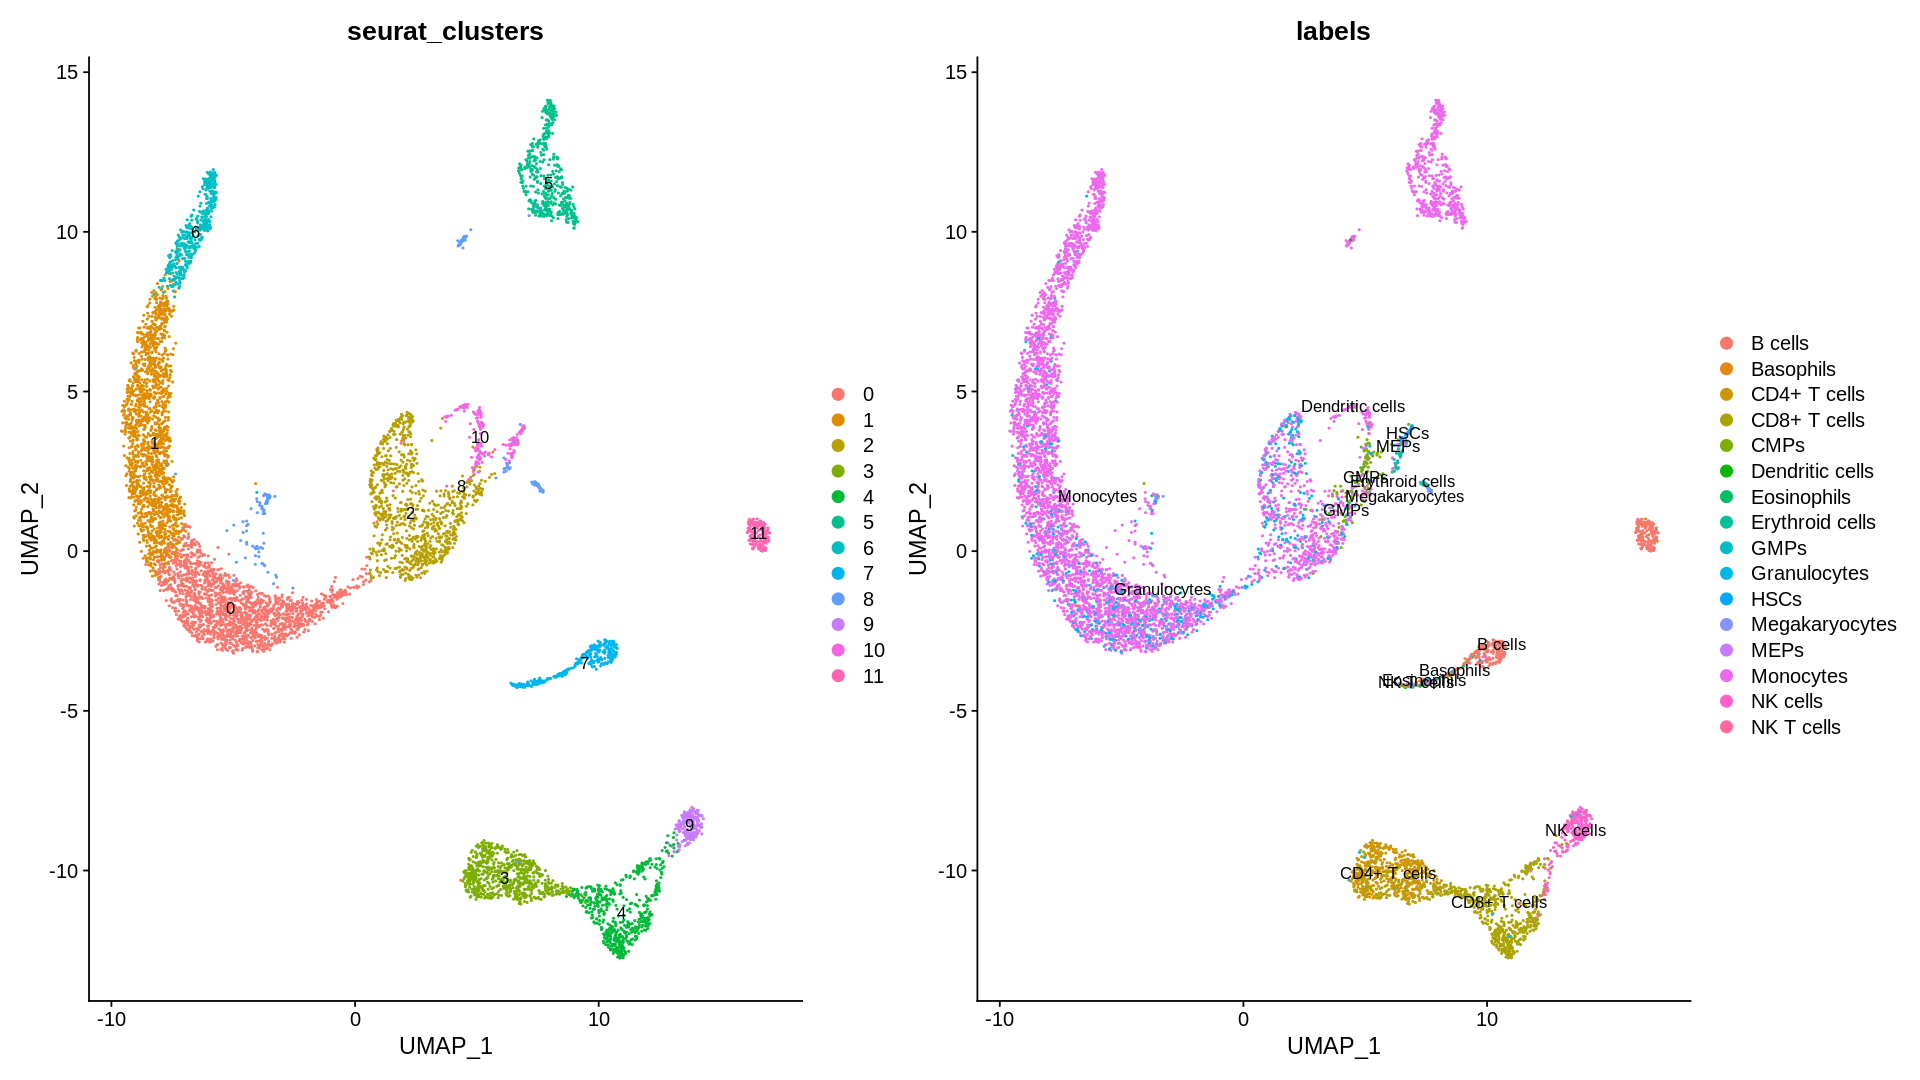

In [43]:
label_plot<-DimPlot(normal2, group.by = c("seurat_clusters","labels"),reduction = "umap",label = TRUE,label.size =3.5)
label_plot

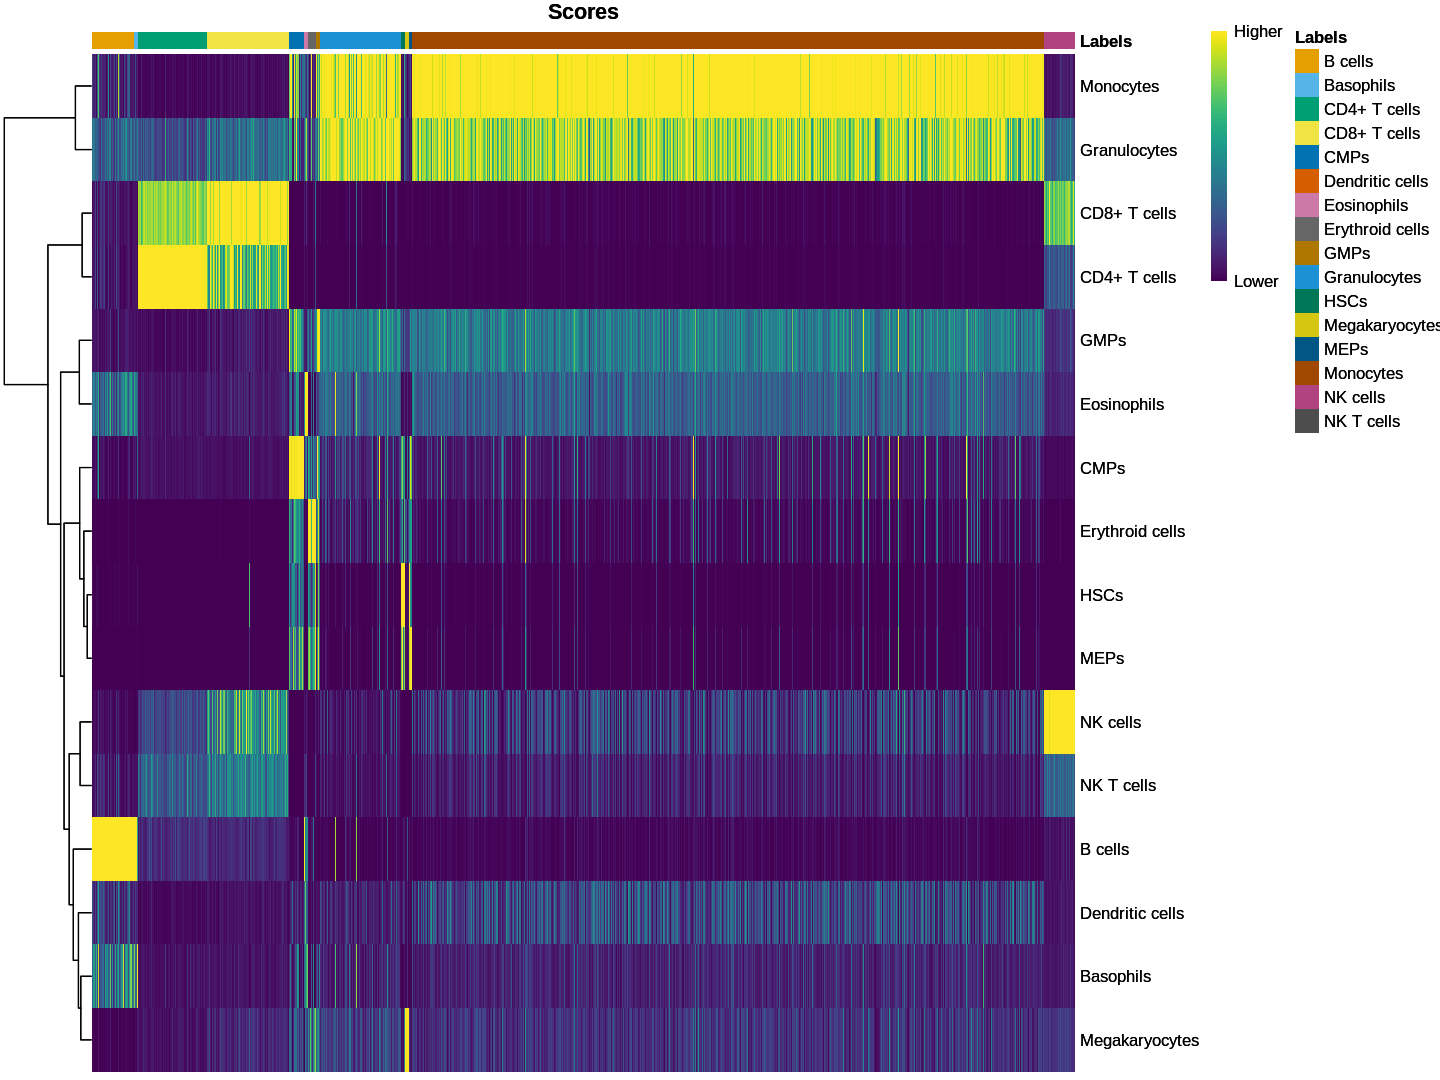

In [44]:
options(repr.plot.height=9,repr.plot.width=12)
plotScoreHeatmap(AL.nhsc)

In [45]:
options(repr.plot.height=9,repr.plot.width=16)

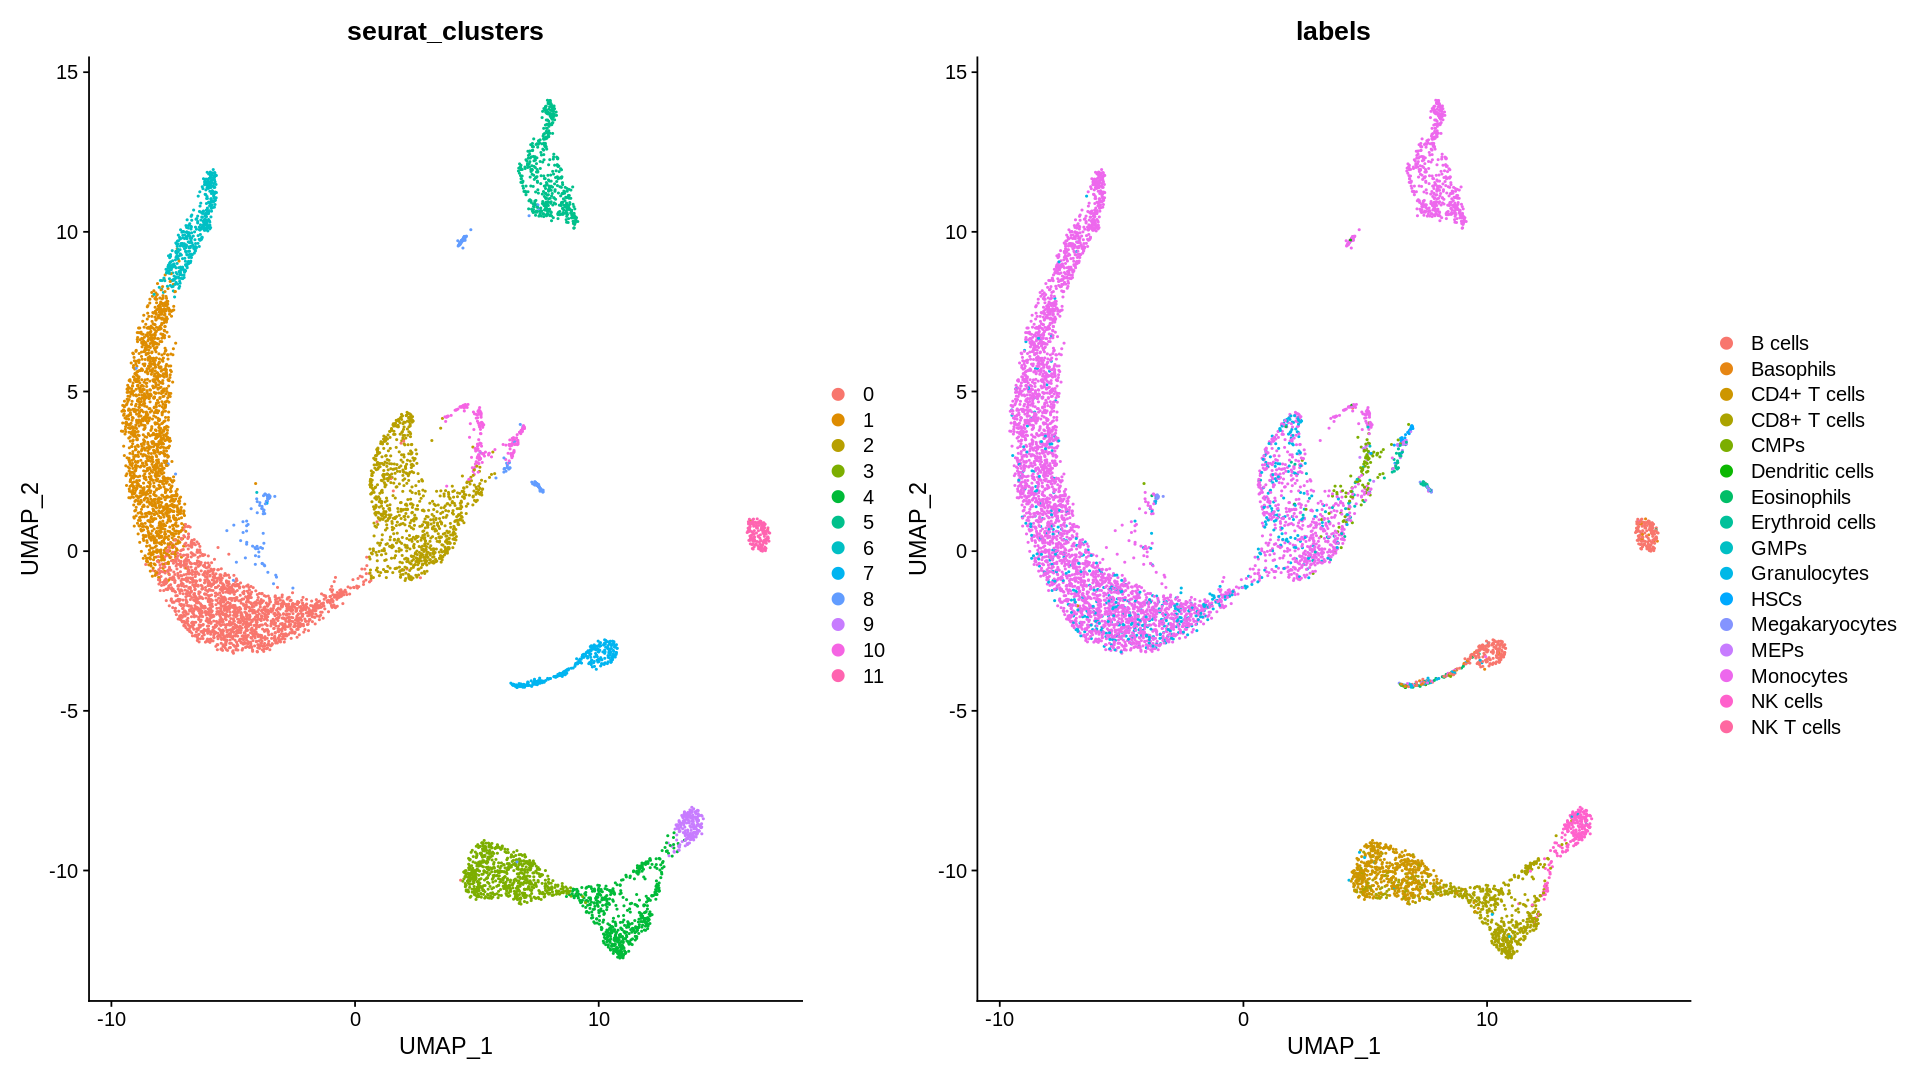

In [46]:
unlabel_plot<-DimPlot(normal2, group.by = c("seurat_clusters","labels"),reduction = "umap")
unlabel_plot

In [47]:
AL.hesc <- SingleR(test = AL_for_SingleR, ref= hpca.se, labels = hpca.se$label.main) 

Warning message:
“Argument 'center' should be of the same length as number of rows of 'x'. Use of a scalar value is deprecated: 1 != 2”
Warning message:
“Argument 'center' should be of the same length as number of rows of 'x'. Use of a scalar value is deprecated: 1 != 26”
Warning message:
“Argument 'center' should be of the same length as number of rows of 'x'. Use of a scalar value is deprecated: 1 != 7”
Warning message:
“Argument 'center' should be of the same length as number of rows of 'x'. Use of a scalar value is deprecated: 1 != 8”
Warning message:
“Argument 'center' should be of the same length as number of rows of 'x'. Use of a scalar value is deprecated: 1 != 2”
Warning message:
“Argument 'center' should be of the same length as number of rows of 'x'. Use of a scalar value is deprecated: 1 != 88”
Warning message:
“Argument 'center' should be of the same length as number of rows of 'x'. Use of a scalar value is deprecated: 1 != 17”
Warning message:
“Argument 'center' should be

In [48]:
meta=normal2@meta.data
table(AL.hesc$labels,meta$seurat_clusters)
normal2@meta.data$labels <-AL.hesc$labels

                   
                       0    1    2    3    4    5    6    7    8    9   10   11
  B_cell               1    0    0    0    0    0    0  205    3    0    0  151
  BM                   4    0    2    1    0    0    0   14    3    0    0    0
  BM & Prog.           0    0    0    0    0    0    0    0    1    0    0    0
  Chondrocytes         0    0    0    0    0    0    0    1    0    0    0    0
  CMP                  0    1    3    0    0    0    0    1   13    0   36    0
  DC                   0    0    0    0    0    0    0    0    3    0    0    0
  Endothelial_cells    0    0    0    0    0    0    0    0    3    0    0    0
  GMP                  0    0    8    0    0    0    0    2    1    0   37    0
  HSC_-G-CSF           0   81    0    0    0    2    1    1    6    0    0    0
  Macrophage           0    0    0    0    0    0    0    0   24    0    0    0
  MEP                  0    0    0    0    0    0    0    0   30    0   23    0
  Monocyte          

In [49]:
type<-as.data.frame(AL.hesc$labels)
count<-table(type)
count

type
           B_cell                BM        BM & Prog.      Chondrocytes 
              360                24                 1                 1 
              CMP                DC Endothelial_cells               GMP 
               54                 3                 3                48 
       HSC_-G-CSF        Macrophage               MEP          Monocyte 
               91                24                53               475 
        Myelocyte       Neutrophils           NK_cell       Osteoblasts 
             3227               804               301                 1 
        Platelets  Pre-B_cell_CD34-  Pro-B_cell_CD34+     Pro-Myelocyte 
               16               115                17               758 
          T_cells Tissue_stem_cells 
             1076                 4 

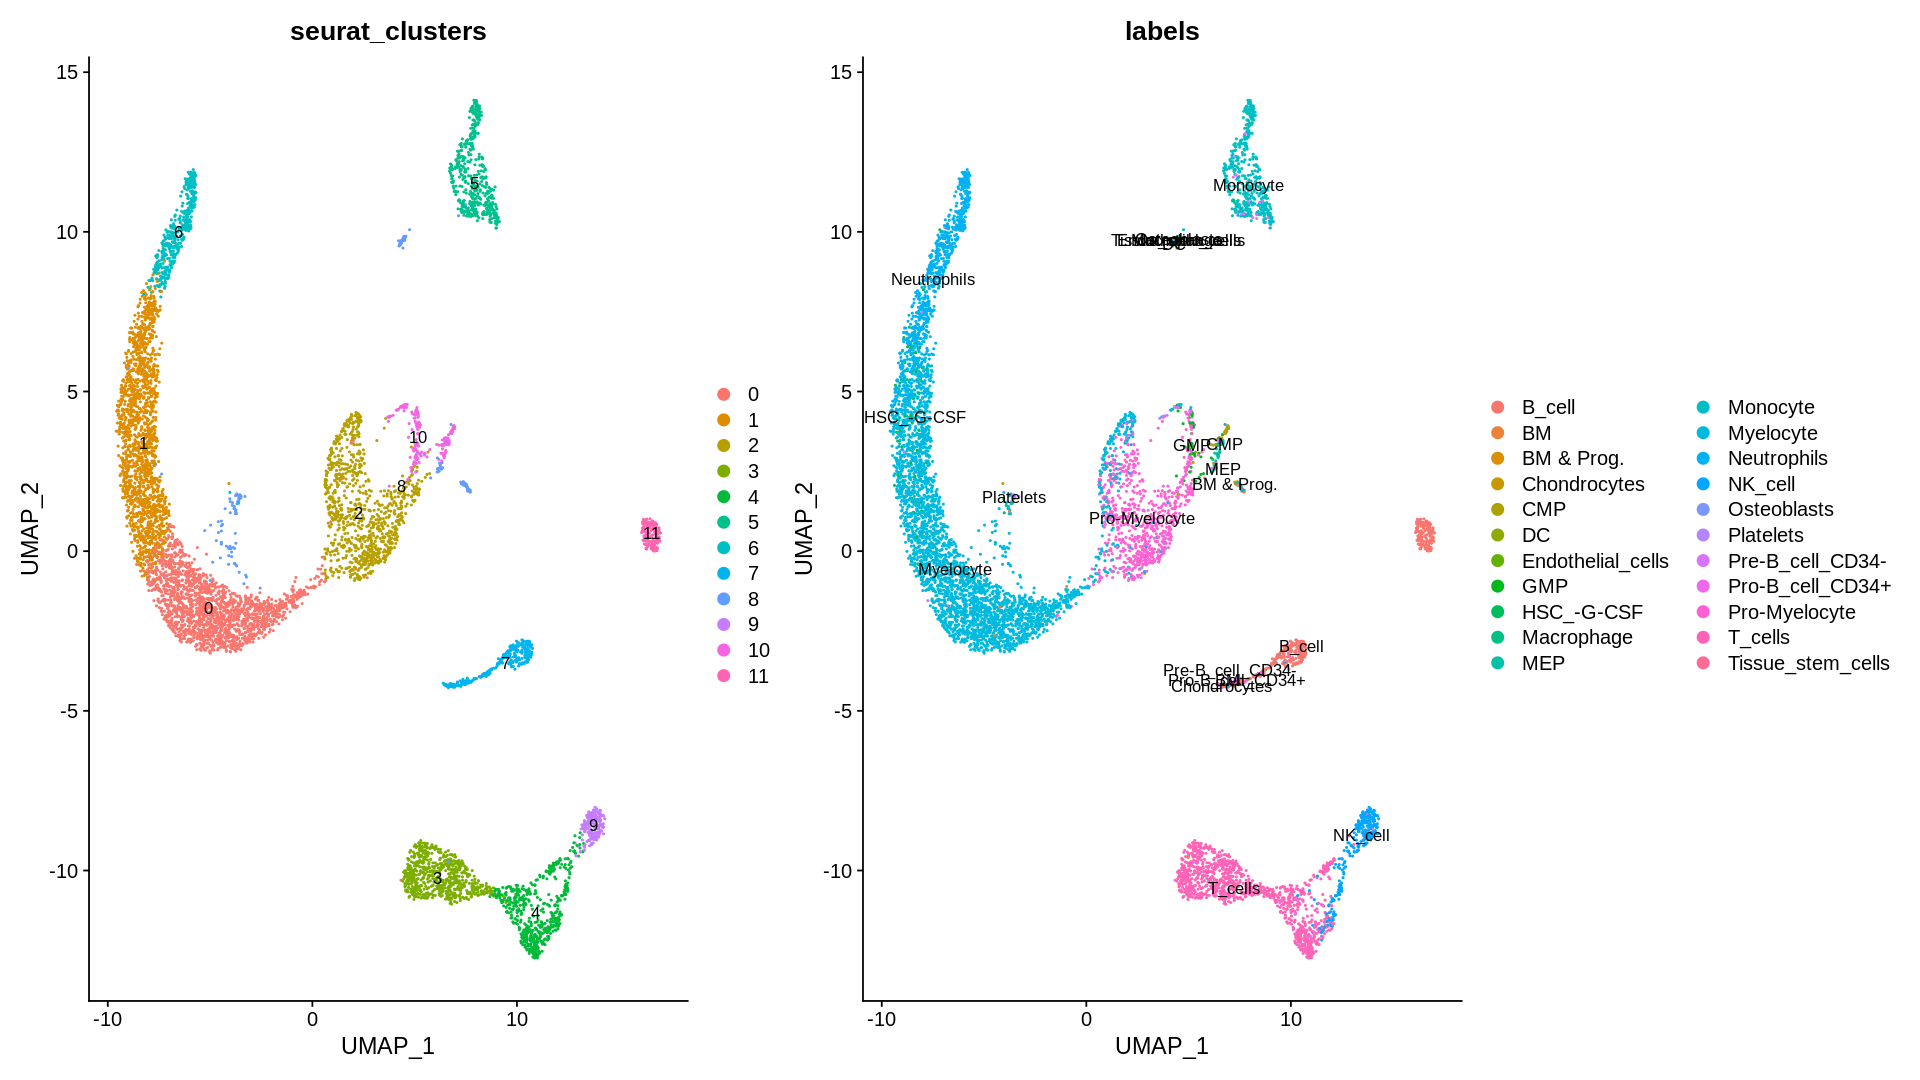

In [50]:
label_plot<-DimPlot(normal2, group.by = c("seurat_clusters","labels"),reduction = "umap",label = TRUE,label.size =3.5)
label_plot

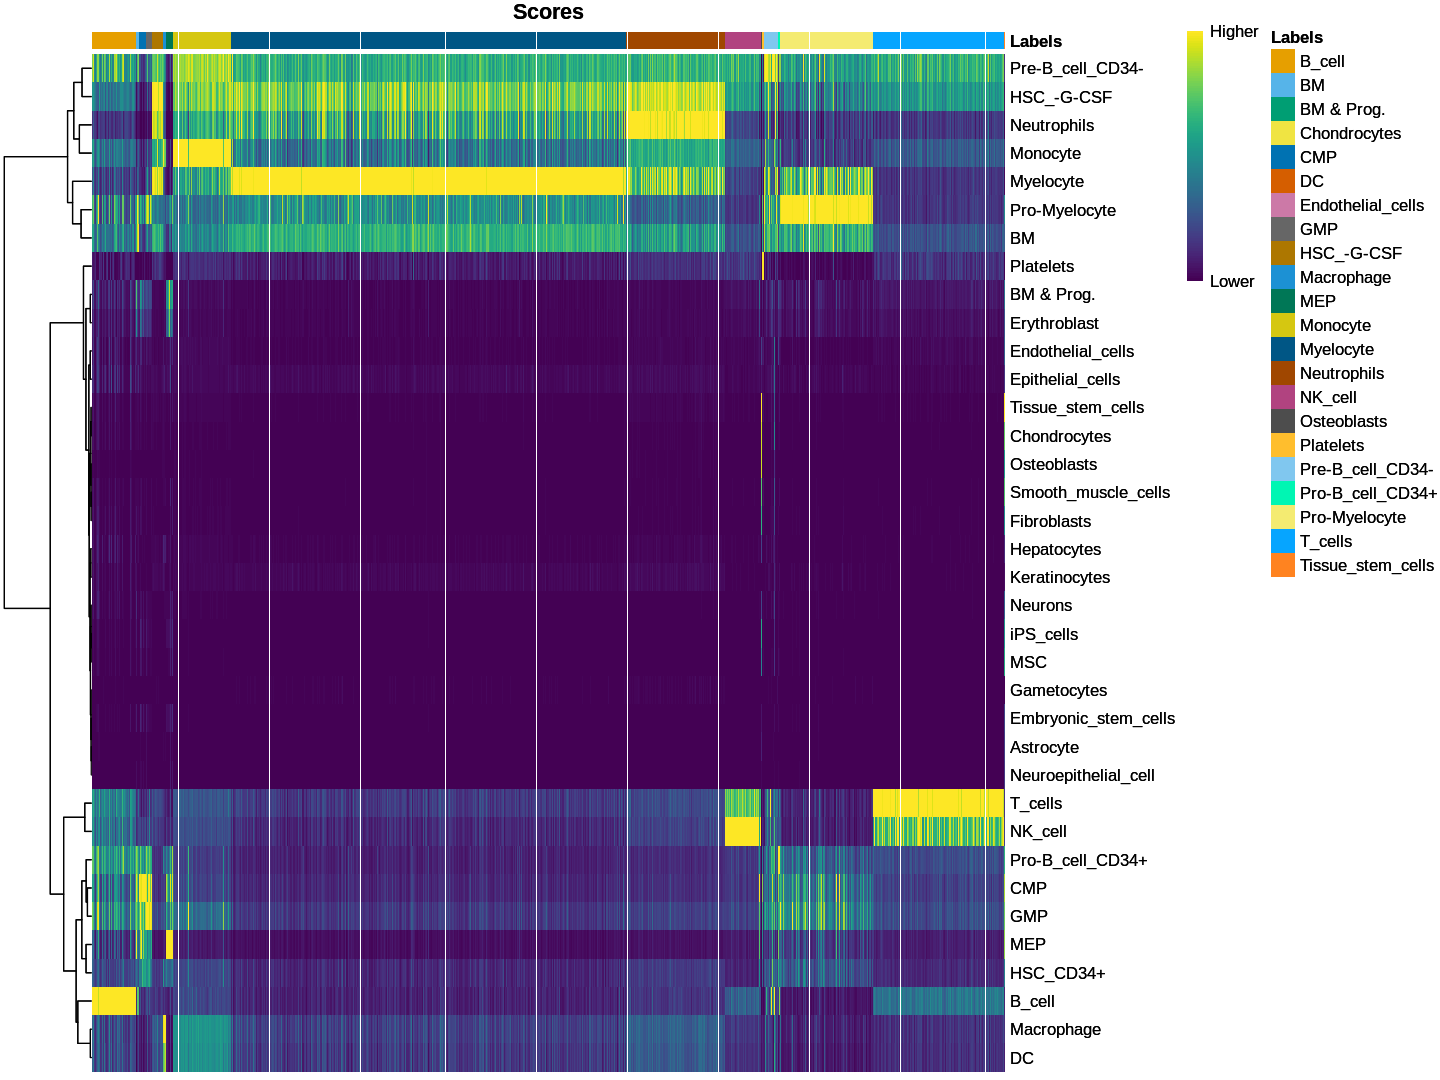

In [51]:
options(repr.plot.height=9,repr.plot.width=12)
plotScoreHeatmap(AL.hesc)

In [52]:
options(repr.plot.height=9,repr.plot.width=16)

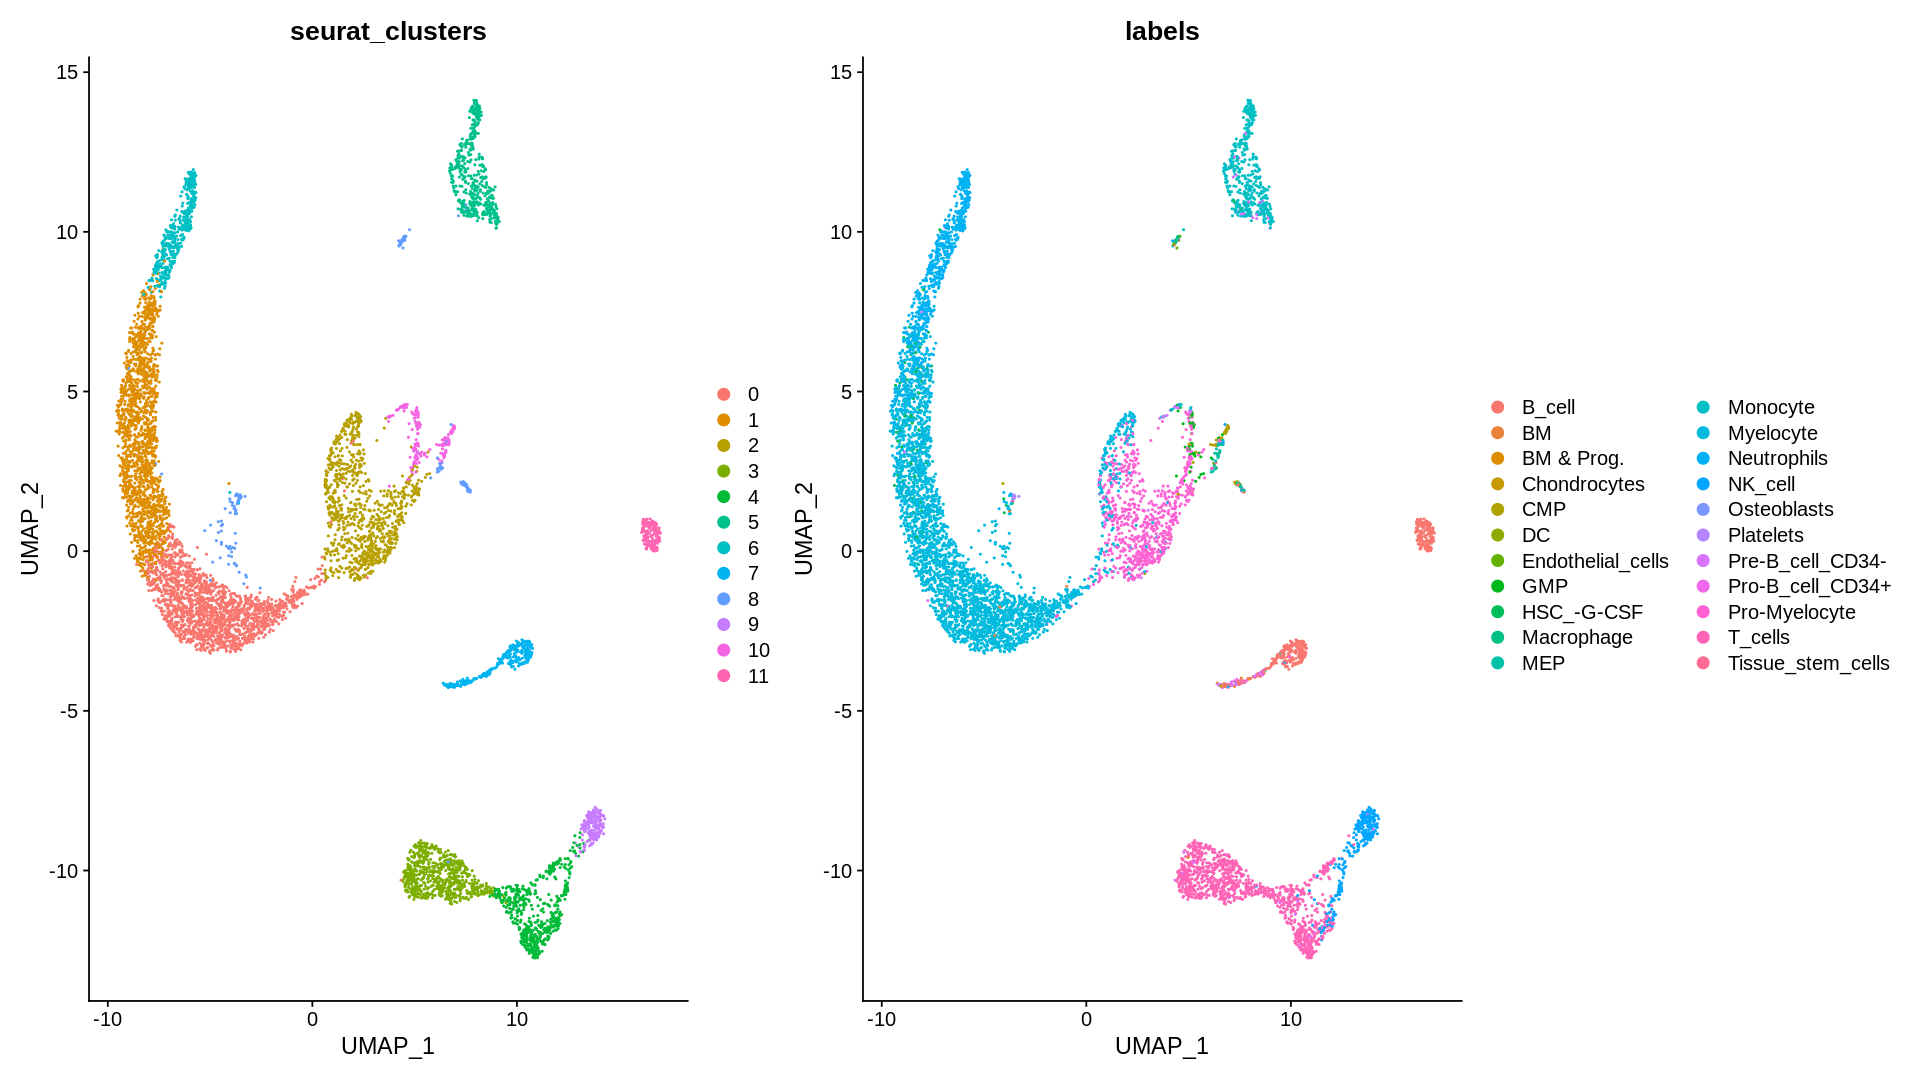

In [53]:
unlabel_plot<-DimPlot(normal2, group.by = c("seurat_clusters","labels"),reduction = "umap")
unlabel_plot

In [54]:
options(repr.plot.height=9,repr.plot.width=7)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



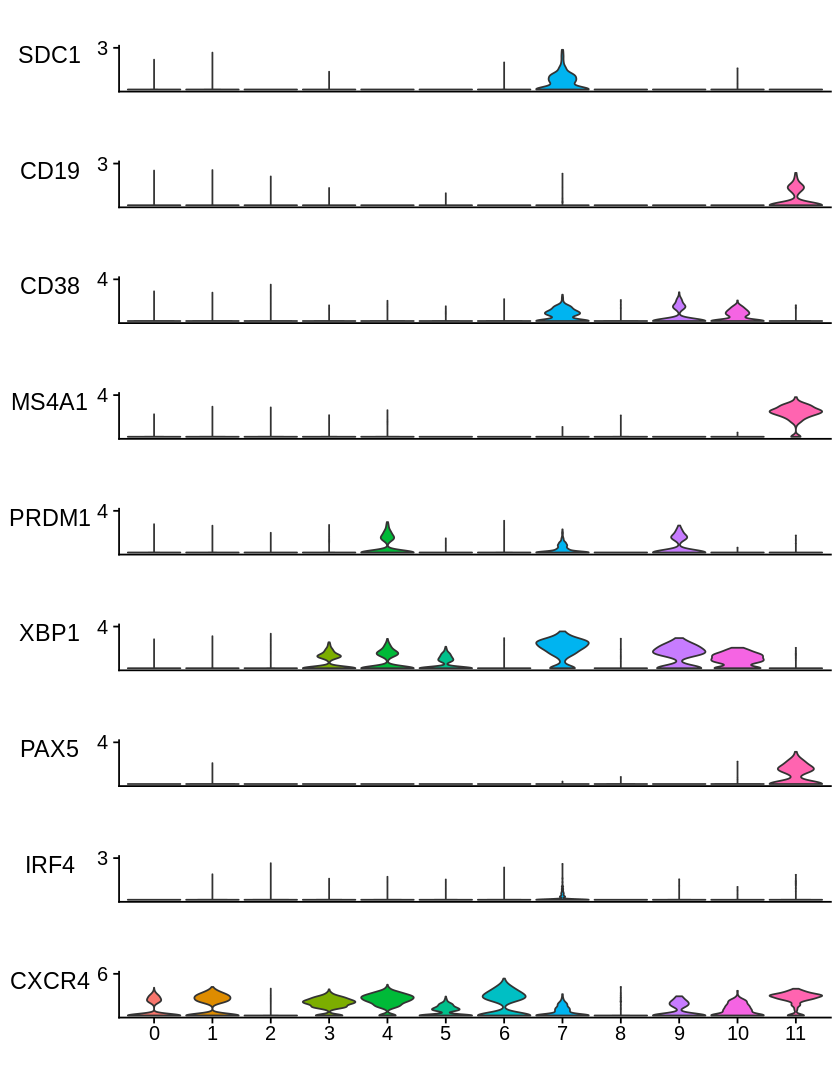

In [55]:
# plasma cell marker
features<- c("SDC1","CD19","CD38","MS4A1","PRDM1","XBP1","PAX5","IRF4","CXCR4")
StackedVlnPlot(obj =normal2, features = features)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



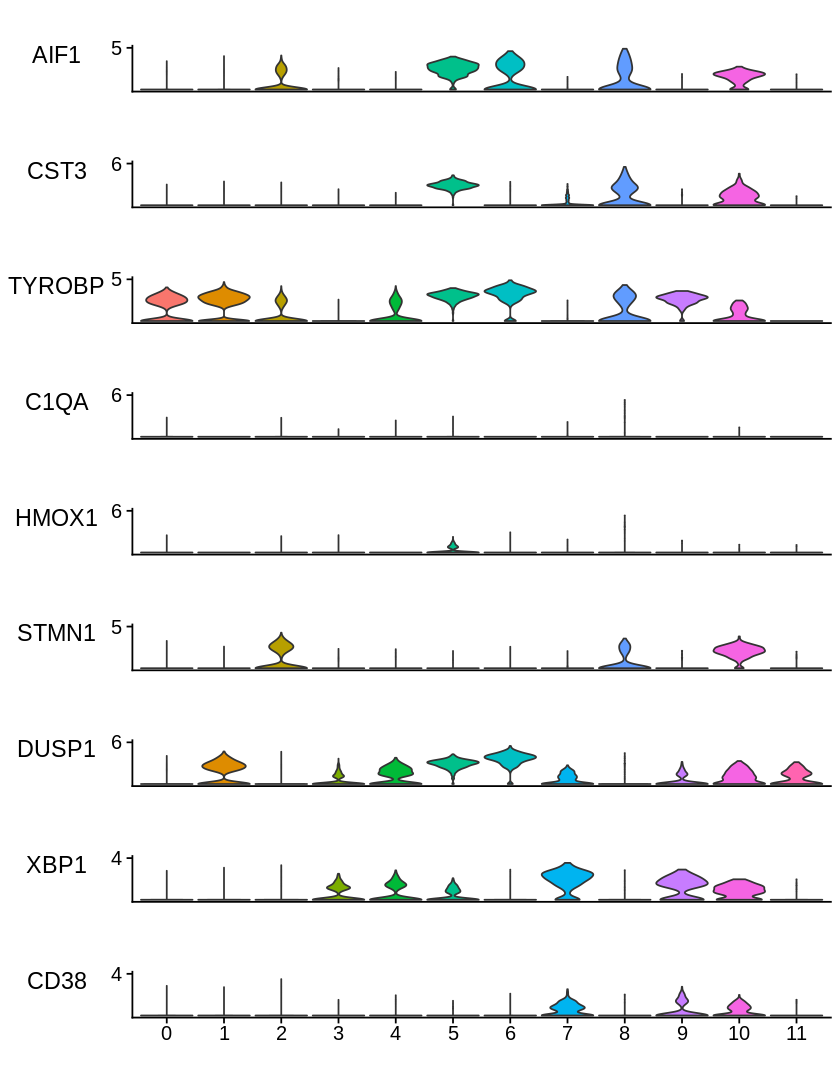

In [56]:
# monocyte?
features<- c("AIF1","CST3","TYROBP","C1QA","HMOX1","STMN1","DUSP1","XBP1","CD38")
StackedVlnPlot(obj =normal2, features = features)

In [57]:
options(repr.plot.height=6,repr.plot.width=6)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



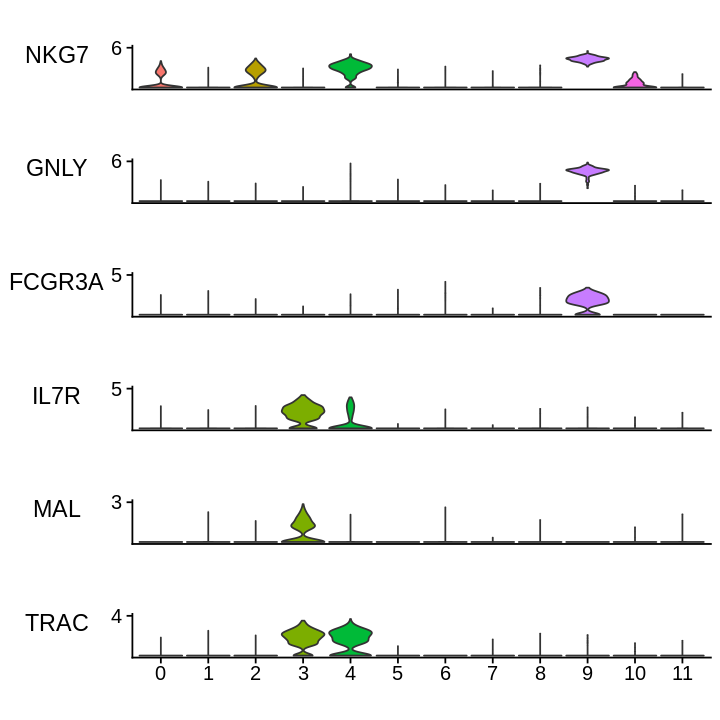

In [58]:
# NK cell
features<- c("NKG7","GNLY","FCGR3A","IL7R","MAL","TRAC")
StackedVlnPlot(obj =normal2, features = features)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



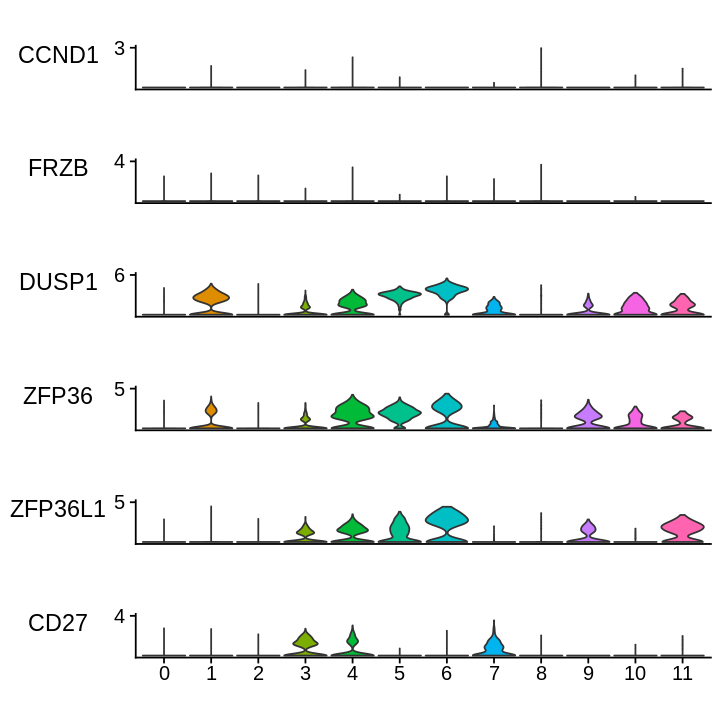

In [59]:
#CCND-dendritic
features<- c("CCND1","FRZB","DUSP1","ZFP36","ZFP36L1","CD27")
StackedVlnPlot(obj =normal2, features = features)

In [60]:
options(repr.plot.height=4,repr.plot.width=8)


Attaching package: ‘ggpubr’


The following object is masked from ‘package:cowplot’:

    get_legend




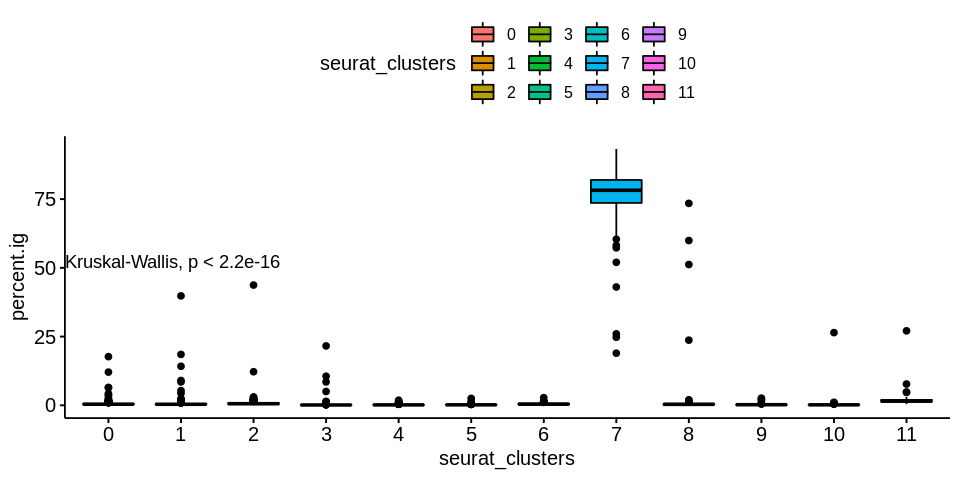

In [61]:
library(ggpubr)
library(RColorBrewer)
ggboxplot(normal2@meta.data, x="seurat_clusters", y="percent.ig", fill = "seurat_clusters")+
  stat_compare_means(label.y = 50)

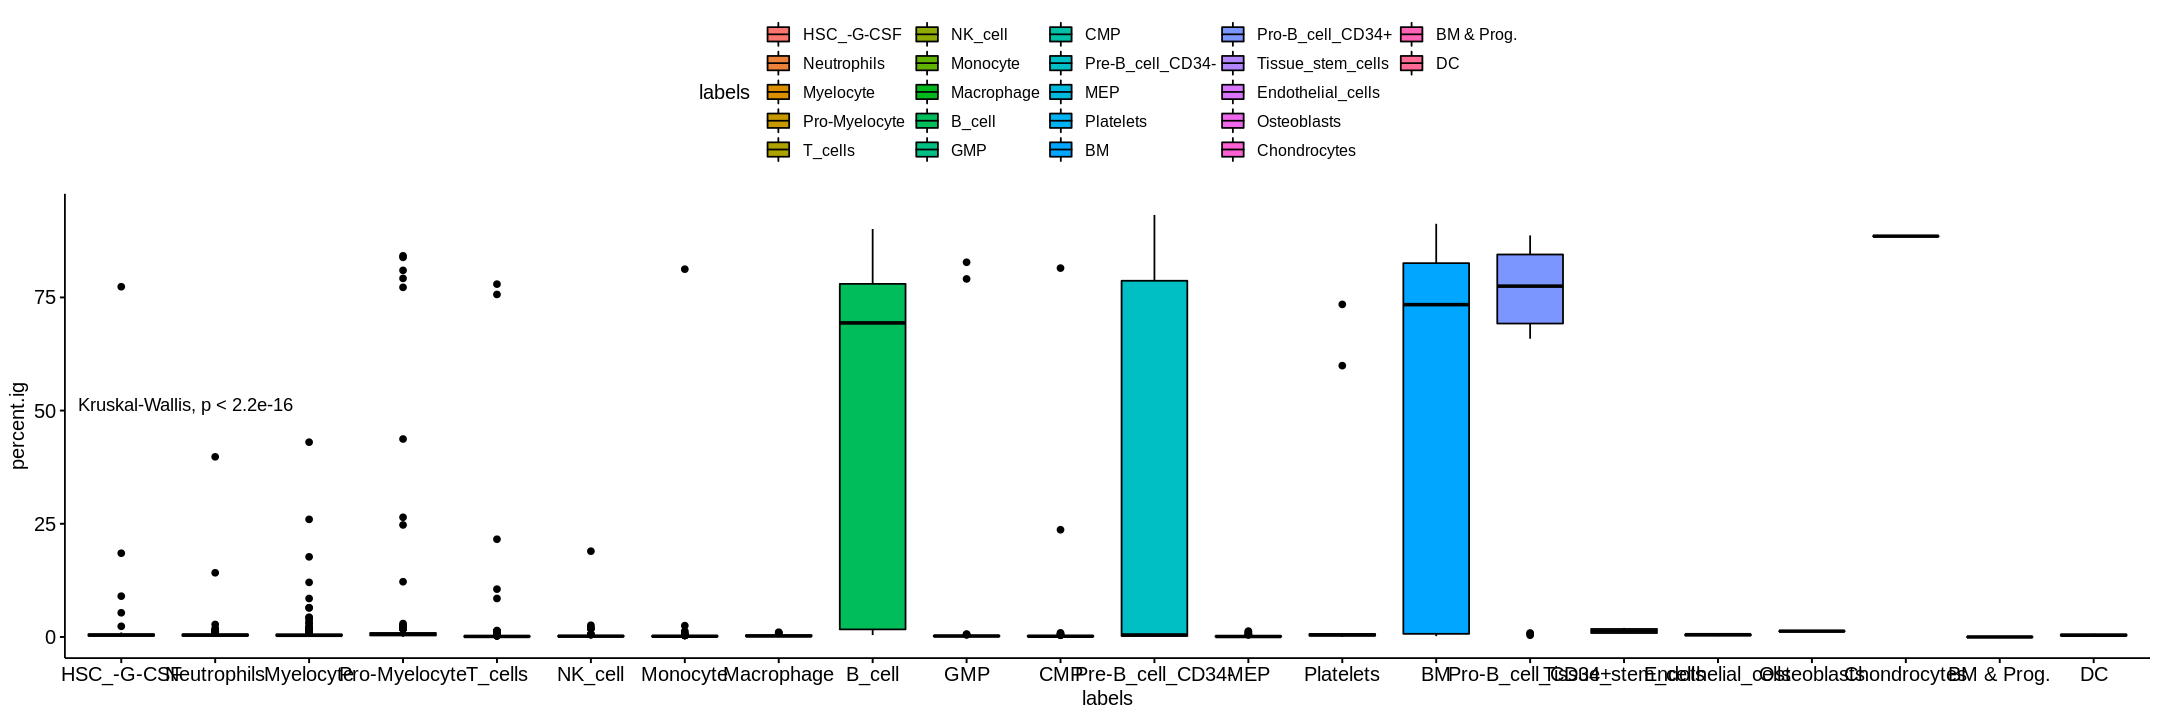

In [62]:
options(repr.plot.height=6,repr.plot.width=18)
ggboxplot(normal2@meta.data, x="labels", y="percent.ig", fill = "labels")+
  stat_compare_means(label.y = 50)

In [63]:
normal3.markers <- FindAllMarkers(normal2, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
normal3.markers %>% group_by(cluster) %>% top_n(n = 5, wt = avg_log2FC)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11



p_val         avg_log2FC pct.1 pct.2 p_val_adj     cluster gene    
1   0.000000e+00 4.195199   0.929 0.193  0.000000e+00 0       CAMP    
2   0.000000e+00 3.842771   0.995 0.281  0.000000e+00 0       LTF     
3   0.000000e+00 3.466679   0.986 0.234  0.000000e+00 0       LCN2    
4   0.000000e+00 2.948156   0.843 0.208  0.000000e+00 0       RETN    
5   0.000000e+00 2.793119   0.770 0.129  0.000000e+00 0       MMP8    
6   0.000000e+00 2.675635   0.961 0.208  0.000000e+00 1       MMP9    
7   0.000000e+00 2.214711   0.989 0.448  0.000000e+00 1       S100A12 
8   0.000000e+00 1.912668   0.566 0.117  0.000000e+00 1       PTGS2   
9   0.000000e+00 1.868479   0.968 0.582  0.000000e+00 1       NCF1    
10 1.096218e-258 1.784540   0.482 0.118 2.274871e-254 1       VNN2    
11  0.000000e+00 6.318689   0.817 0.072  0.000000e+00 2       DEFA3   
12  0.000000e+00 6.078987   0.766 0.028  0.000000e+00 2       DEFA4   
13  0.000000e+00 5.101573   0.820 0.065  0.000000e+00 2       AZU1    
14  0.000000e+00 4.764305   0.667 0.046  0.000000e+00 2       ELANE   
15  0.000000e+00 4.620743   0.574 0.050  0.000000e+00 2       PRTN3   
16  0.000000e+00 2.956666   0.842 0.029  0.000000e+00 3       IL7R    
17  0.000000e+00 2.513448   0.948 0.189  0.000000e+00 3       LTB     
18  0.000000e+00 2.387548   0.879 0.064  0.000000e+00 3       TRAC    
19  0.000000e+00 2.308652   1.000 0.607  0.000000e+00 3       RPS18   
20  0.000000e+00 2.283463   0.967 0.103  0.000000e+00 3       IL32    
21  0.000000e+00 4.437564   0.836 0.045  0.000000e+00 4       CCL4    
22  0.000000e+00 4.187261   0.968 0.056  0.000000e+00 4       CCL5    
23  0.000000e+00 3.810381   0.819 0.015  0.000000e+00 4       GZMK    
24  0.000000e+00 3.325004   0.940 0.123  0.000000e+00 4       IL32    
25  0.000000e+00 3.243742   0.936 0.040  0.000000e+00 4       GZMA    
26  0.000000e+00 4.407420   0.969 0.015  0.000000e+00 5       VCAN    
27  0.000000e+00 3.443573   0.996 0.081  0.000000e+00 5       CST3    
28  0.000000e+00 2.790623   0.913 0.022  0.000000e+00 5       CD14    
29  0.000000e+00 2.786944   0.958 0.071  0.000000e+00 5       IFI30   
30  0.000000e+00 2.755014   0.902 0.016  0.000000e+00 5       CD36    
31  0.000000e+00 5.480099   0.619 0.050  0.000000e+00 6       CXCL8   
32  0.000000e+00 4.319173   0.991 0.224  0.000000e+00 6       NAMPT   
33  0.000000e+00 3.881063   0.960 0.124  0.000000e+00 6       FCGR3B  
34  0.000000e+00 3.636295   0.815 0.070  0.000000e+00 6       CMTM2   
35 6.190486e-261 4.009435   0.981 0.506 1.284650e-256 6       NEAT1   
36 3.549427e-186 7.224082   0.788 0.133 7.365771e-182 7       IGLC1   
37 6.330642e-146 6.617695   0.497 0.067 1.313735e-141 7       IGHG2   
38  6.187730e-73 7.685620   0.712 0.233  1.284078e-68 7       IGLC3   
39  8.849593e-46 7.369312   0.979 0.893  1.836468e-41 7       IGKC    
40  3.137772e-25 7.657103   0.829 0.481  6.511504e-21 7       IGLC2   
41  0.000000e+00 5.009718   0.450 0.012  0.000000e+00 8       PF4     
42 8.531568e-303 5.459910   0.503 0.021 1.770471e-298 8       PPBP    
43 3.232334e-215 3.175115   0.302 0.009 6.707739e-211 8       GNG11   
44 6.866160e-144 4.232757   0.529 0.062 1.424866e-139 8       GP1BB   
45  4.819186e-89 3.625023   0.407 0.058  1.000077e-84 8       NRGN    
46  0.000000e+00 5.831775   1.000 0.027  0.000000e+00 9       GNLY    
47  0.000000e+00 4.467865   0.984 0.014  0.000000e+00 9       GZMB    
48  0.000000e+00 4.131007   0.947 0.013  0.000000e+00 9       FGFBP2  
49  0.000000e+00 4.022691   1.000 0.047  0.000000e+00 9       PRF1    
50 1.194059e-189 3.950619   1.000 0.258 2.477911e-185 9       NKG7    
51 2.608704e-238 2.108165   0.951 0.112 5.413582e-234 10      STMN1   
52 5.213971e-126 2.000221   0.984 0.294 1.082003e-121 10      HSP90AB1
53 1.316197e-108 2.051221   1.000 0.442 2.731372e-104 10      RPLP0   
54  1.296009e-95 2.763834   0.643 0.126  2.689478e-91 10      MPO     
55  1.502330e-72 2.281270   0.524 0.103  3.117635e-68 10      PRTN3   
56  0.000000e+00 3.549072  

In [64]:
options(repr.plot.height=10,repr.plot.width=10)

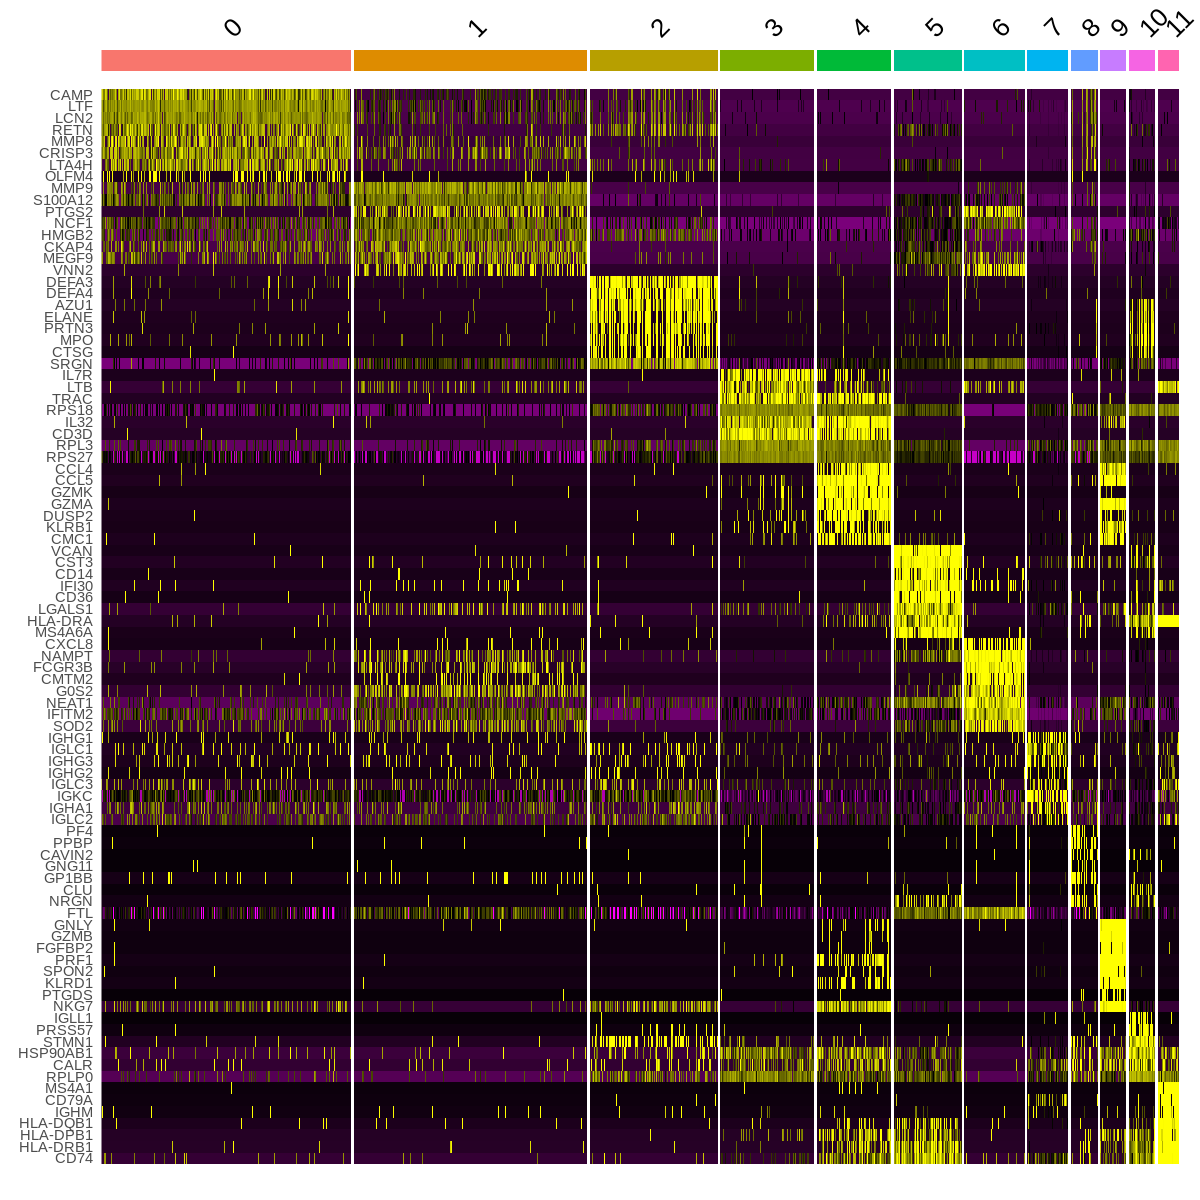

In [65]:
top10 <- normal3.markers %>% group_by(cluster) %>% top_n(n = 8, wt = avg_log2FC)
DoHeatmap(normal2, features = top10$gene) + NoLegend()

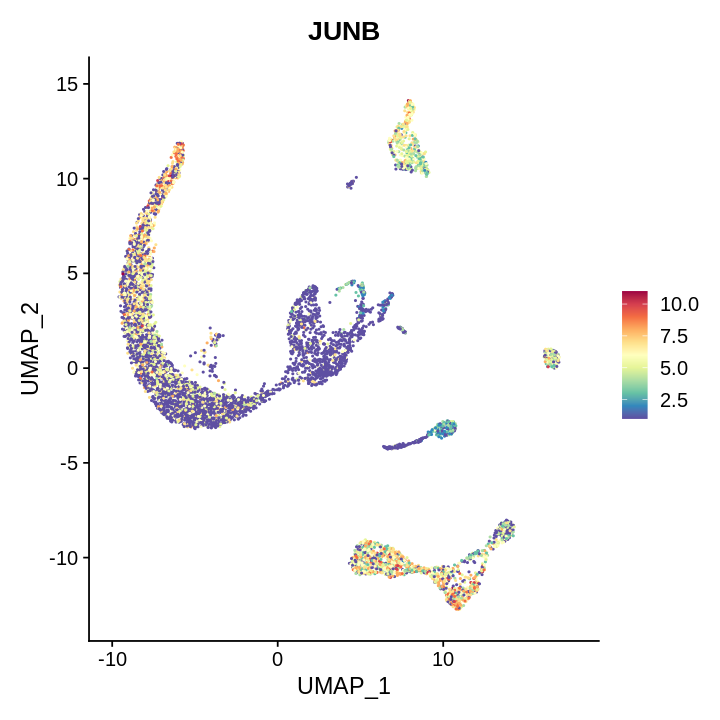

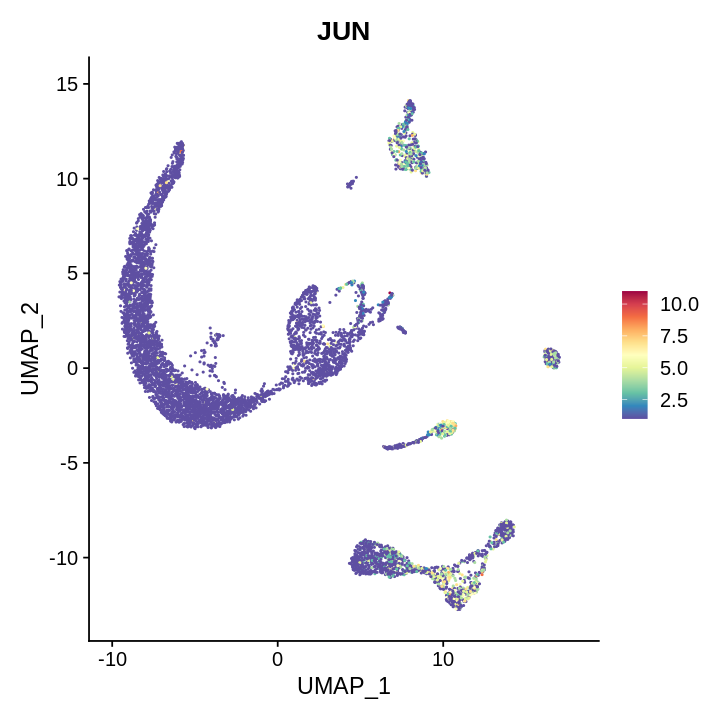

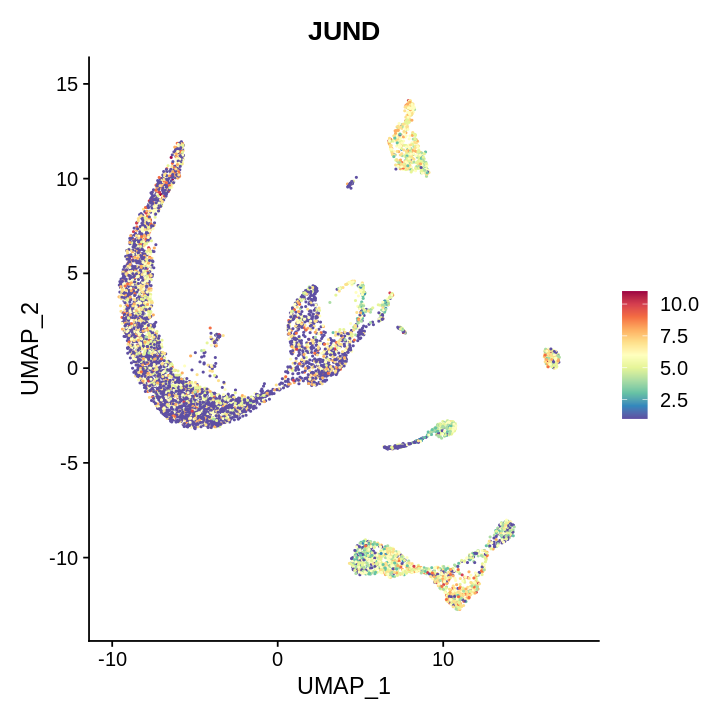

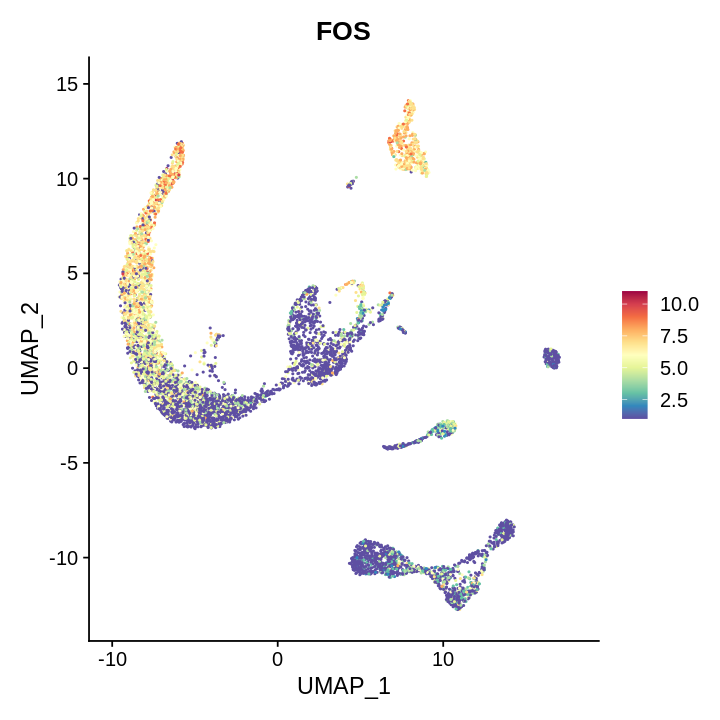

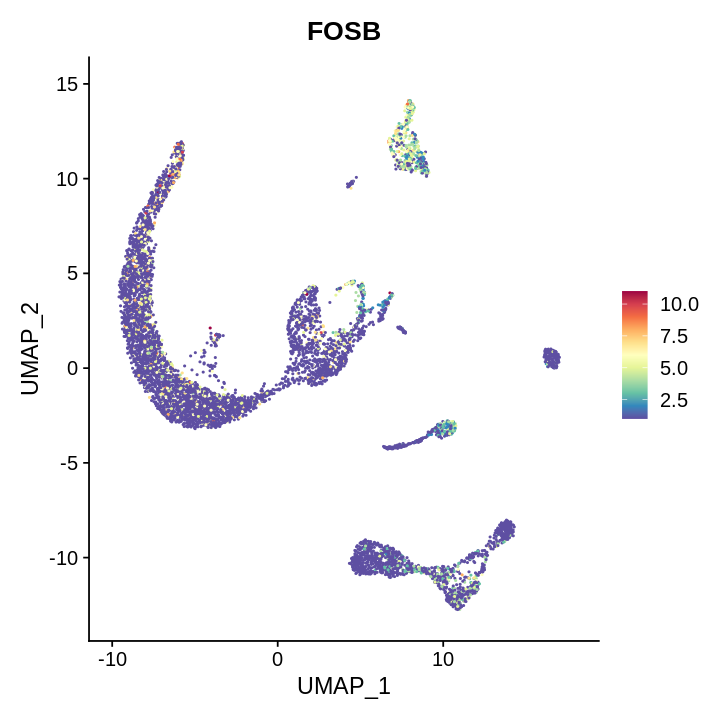

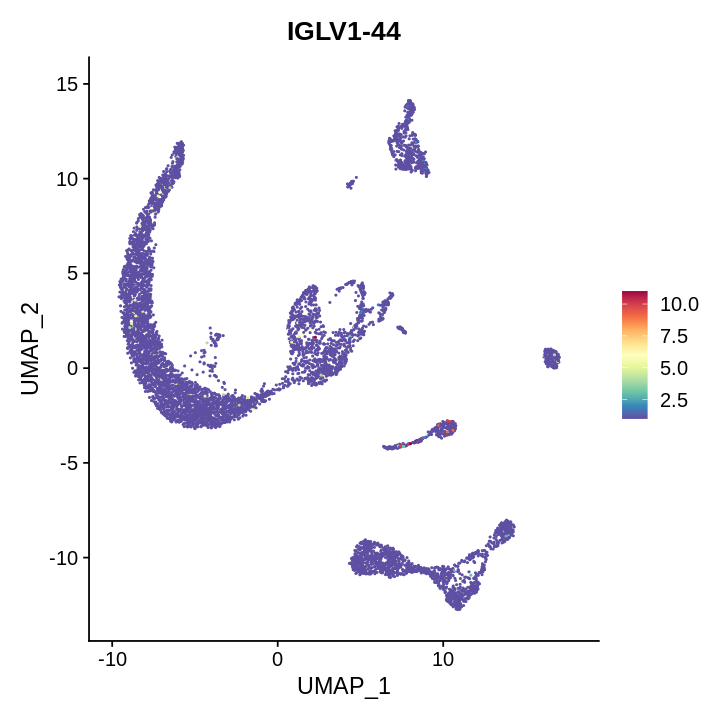

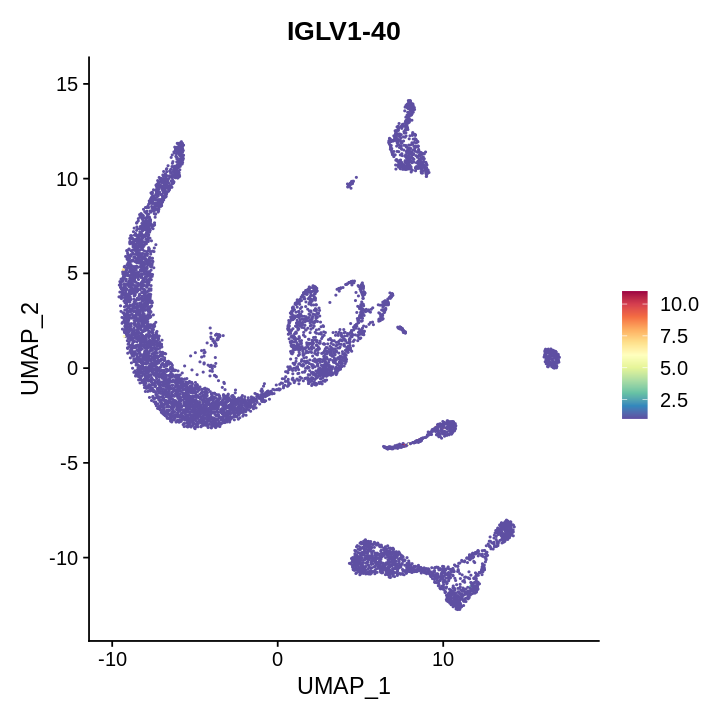

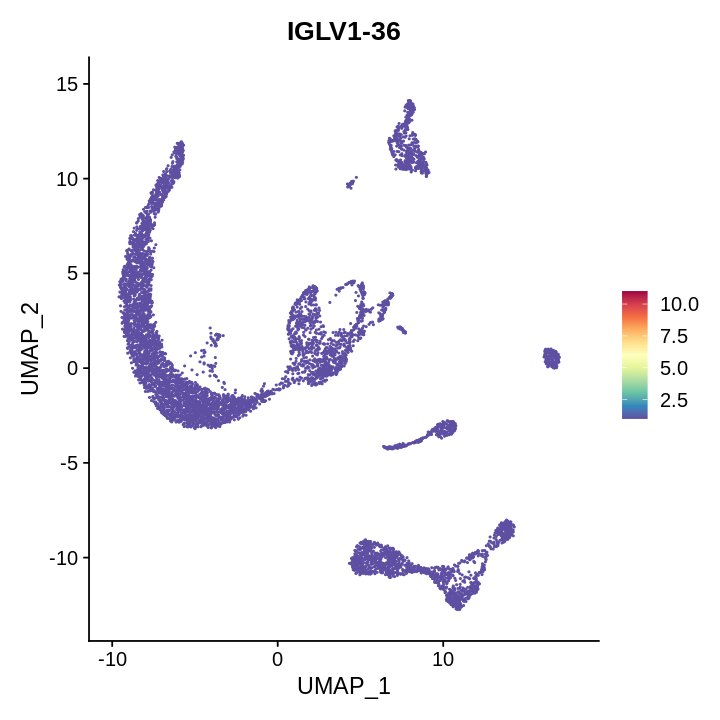

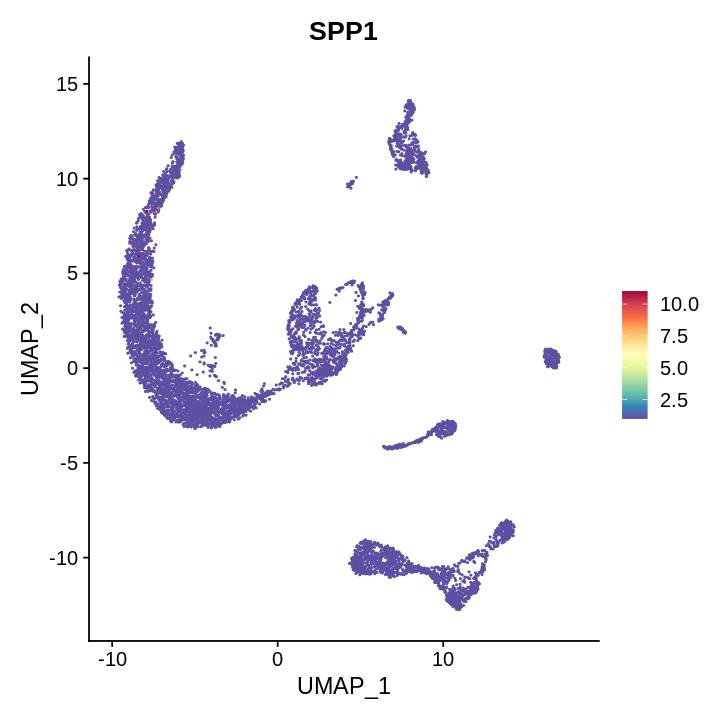

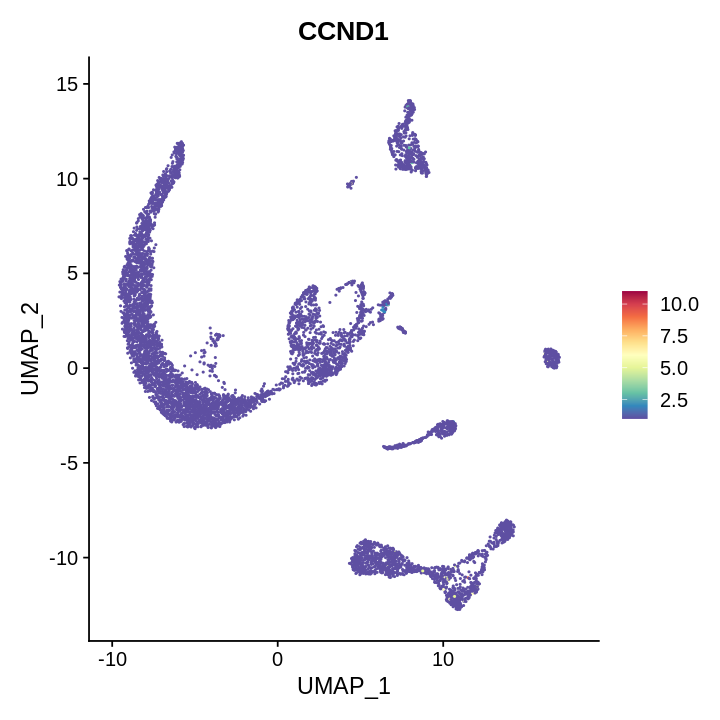

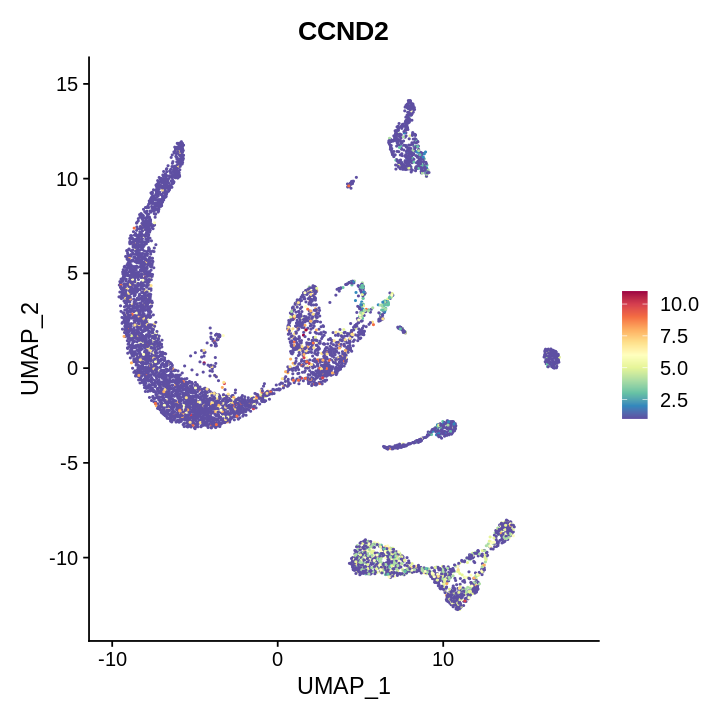

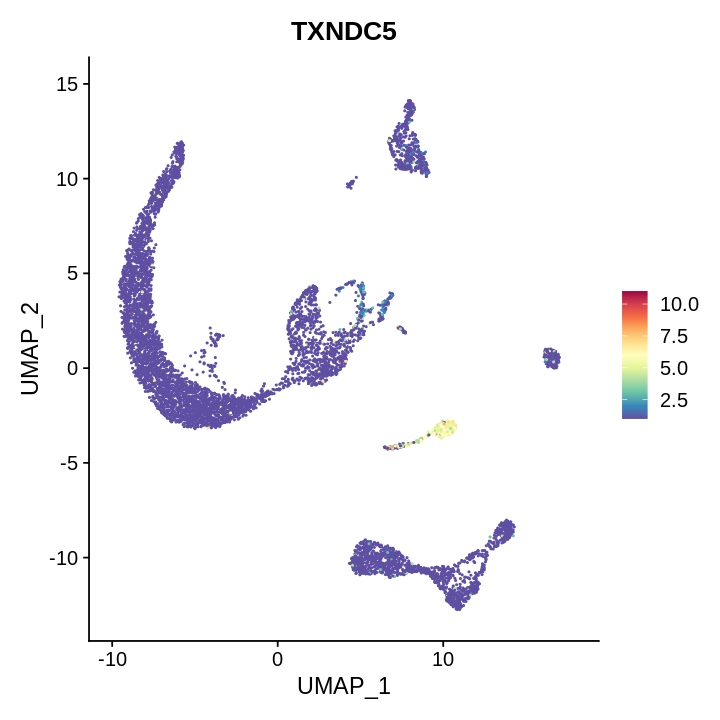

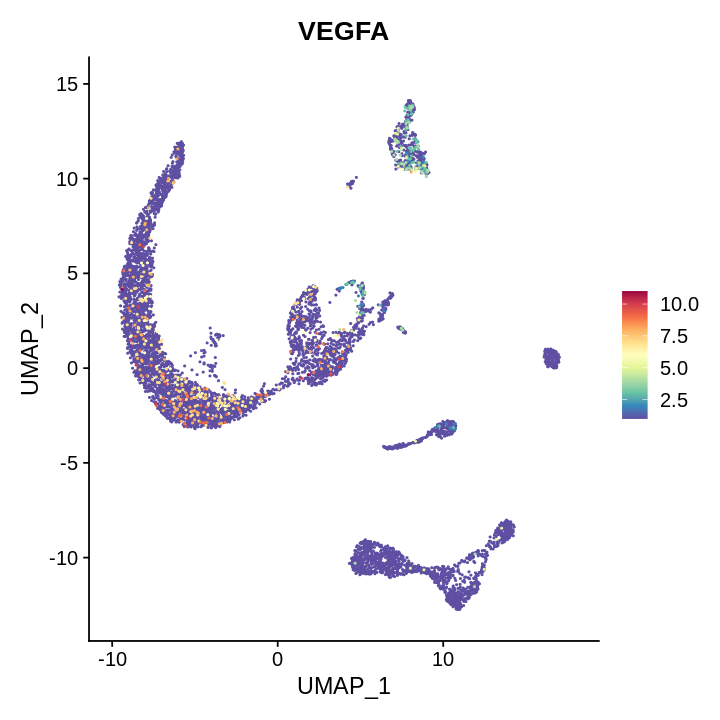

In [66]:
options(repr.plot.height=6,repr.plot.width=6)
FeaturePlot(normal2, features = c('JUNB'),cols=rev(brewer.pal(11,'Spectral')))
FeaturePlot(normal2, features = c('JUN'),cols=rev(brewer.pal(11,'Spectral')))
FeaturePlot(normal2, features = c('JUND'),cols=rev(brewer.pal(11,'Spectral')))
FeaturePlot(normal2, features = c('FOS'),cols=rev(brewer.pal(11,'Spectral')))
FeaturePlot(normal2, features = c('FOSB'),cols=rev(brewer.pal(11,'Spectral')))
FeaturePlot(normal2, features = c('IGLV1-44'),cols=rev(brewer.pal(11,'Spectral')))
FeaturePlot(normal2, features = c('IGLV1-40'),cols=rev(brewer.pal(11,'Spectral')))
FeaturePlot(normal2, features = c('IGLV1-36'),cols=rev(brewer.pal(11,'Spectral')))
FeaturePlot(normal2, features = c('SPP1'),cols=rev(brewer.pal(11,'Spectral')))
FeaturePlot(normal2, features = c('CCND1'),cols=rev(brewer.pal(11,'Spectral')))
FeaturePlot(normal2, features = c('CCND2'),cols=rev(brewer.pal(11,'Spectral')))
FeaturePlot(normal2, features = c('TXNDC5'),cols=rev(brewer.pal(11,'Spectral')))
FeaturePlot(normal2, features = c('VEGFA'),order=TRUE,cols=rev(brewer.pal(11,'Spectral')))

In [67]:
save(normal2,file="0819-POEMS14-3.Rda")

In [ ]:
normal2